# Introduction

We are going to fix a 5-year bugs in the RNA-seq pipeline, i.e. the strandness mistake. We took for granted that all the samples before and after CCLE 2019 papers are coming from the non-stranded protocols, but it is not true. We will systematically benchmark the effects.

## Outline
- [Setup](#setup)
- [Strandness](#understanding-strandness-statistics)
- [All genes impact](#all-genes-expression-benchmarking)
- [Protein coding genes impact](#protein-coding-genes-impact)

# Setup 

First, we need to setup the environment for the experiments.

In [1]:
import pandas as pd
import dalmatian as dm
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from sklearn.decomposition import PCA
tc = TaigaClient()
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')

In [2]:
mybiomart = helper.generateGeneNames(ensemble_server="http://nov2020.archive.ensembl.org/biomart", useCache=False)
protcod_rename = {}
protcod_ensem = []
for _, i in mybiomart[
    (~mybiomart.entrezgene_id.isna()) & (mybiomart.gene_biotype == "protein_coding")
].iterrows():
    if i.ensembl_gene_id not in protcod_rename:
        protcod_rename.update(
            {
                i.hgnc_symbol + " (" + i.ensembl_gene_id + ")": i.hgnc_symbol
                + " ("
                + str(int(i.entrezgene_id))
                + ")"
            }
        )
        protcod_ensem.append(i.ensembl_gene_id)

downloading gene names from biomart


/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [3]:
allgenes_rename = {}
for _, i in mybiomart.iterrows():
    if i.ensembl_gene_id not in allgenes_rename:
        if i.hgnc_symbol:
            allgenes_rename.update(
                {
                    i.ensembl_gene_id: i.hgnc_symbol
                    + " ("
                    + str(i.ensembl_gene_id)
                    + ")"
                }
            )
        else:
            allgenes_rename.update(
                {
                    i.ensembl_gene_id: i.ensembl_gene_id
                }
            )

In [9]:
len(protcod_ensem)

21704

In [10]:
model_dataset = pd.read_table("~/public_ccle_rna.csv", index_col=0)

In [12]:
wm = dm.WorkspaceManager("broad-firecloud-ccle/DepMap_hg38_RNAseq")
terra_rnaseq_df = wm.get_samples()

dev_wm = dm.WorkspaceManager("broad-firecloud-ccle/Dev_DepMap_hg38_RNAseq")
dev_terra_rnaseq_df = dev_wm.get_samples()

inputs = terra_rnaseq_df.rna_strand_output[~terra_rnaseq_df.rna_strand_output.isnull()]

#arxspan_id

profile_ids = terra_rnaseq_df.ProfileID[~terra_rnaseq_df.rna_strand_output.isnull()]
#meta = pd.read_table("~/all_meta_oncotree.tsv")

In [9]:
terra_rnaseq_df.loc[:, ['arxspan_id', 'stranded']]

arxspan_id stranded
sample_id                      
CDS-010xbm  ACH-001113     True
CDS-02TzJp  ACH-001289     True
CDS-04NSe4  ACH-003062     True
CDS-0693hw  ACH-001339     True
CDS-07Plat  ACH-001619     True
...                ...      ...
CDS-ZyA0IW  ACH-003142     True
CDS-ZyDz4O  ACH-000323    False
CDS-zYpKQj  ACH-000830    False
CDS-ZZa1qq  ACH-002949     True
CDS-ZZR42Y  ACH-000438    False

[2222 rows x 2 columns]

# Understanding strandness statistics

In [10]:
def load_rnaseqc(terra_path):
    rnaseqc_count_df = pd.read_csv(terra_path, sep=':', skiprows=3, header=None, index_col=0)
    return rnaseqc_count_df

from multiprocessing import Pool
pool = Pool(12)
strand_count_dfs = pool.map(load_rnaseqc, inputs)
pool.close()
strand_count_dfs = pd.concat(strand_count_dfs, axis=1)
strand_count_dfs = strand_count_dfs.T
strand_count_dfs.index = inputs.index

In [21]:
strand_count_dfs.loc['CDS-5RKqty']

0
Fraction of reads failed to determine               0.0124
Fraction of reads explained by "1++,1--,2+-,2-+"    0.0248
Fraction of reads explained by "1+-,1-+,2++,2--"    0.9628
Profile                                                NaN
model_id                                               NaN
Name: CDS-5RKqty, dtype: object

In [22]:
strand_count_dfs.loc[:, "Profile"] = strand_count_dfs.index.map(dict(zip(model_dataset.main_sequencing_id, model_dataset.profile_id)))

In [23]:
strand_count_dfs['model_id'] = strand_count_dfs.index.map(dict(zip(model_dataset.main_sequencing_id, model_dataset.model_id)))

In [24]:
strand_count_dfs.model_id.isnull().sum()

70

In [25]:
strand_count_dfs.shape

(2222, 5)

<Axes: xlabel='Fraction of reads explained by "1++,1--,2+-,2-+"', ylabel='Density'>

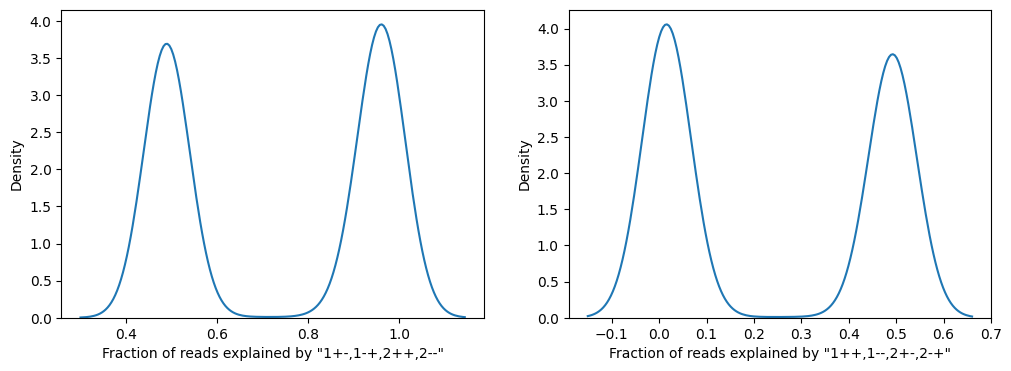

In [26]:
strand_count_dfs.loc[:, 'strandness'] = strand_count_dfs.iloc[:, 2] > 0.7
strand_count_dfs.to_csv("rna_strandness_24q2_fill_latest.csv")
import seaborn as sns
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
sns.kdeplot(strand_count_dfs.iloc[:, 2], ax=ax[0])
sns.kdeplot(strand_count_dfs.iloc[:, 1], ax=ax[1])

In [27]:
strand_count_dfs_modeling = strand_count_dfs.loc[:, ['model_id', 'strandness']].set_index("model_id")
strand_count_dfs_modeling = strand_count_dfs_modeling[~strand_count_dfs_modeling.index.isnull()]

In [16]:
strand_count_dfs_modeling['strandness'] = strand_count_dfs_modeling['strandness'].astype(int)

In [17]:
strand_count_dfs_modeling.strandness.value_counts()

1    1129
0    1023
Name: strandness, dtype: int64

In [18]:
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')

In [19]:
OmicsDefaultModelProfiles.head()

ModelID  ProfileID ProfileType
0  ACH-000629  PR-CPuQvQ         rna
1  ACH-000905  PR-Zbxz7C         rna
2  ACH-000905  PR-uWKgcA         dna
3  ACH-000358  PR-fqjQgt         rna
4  ACH-000358  PR-TwNLyX         dna

In [20]:
strand_count_dfs_modeling = strand_count_dfs_modeling.loc[strand_count_dfs_modeling.index.isin(OmicsDefaultModelProfiles.ModelID), :]

In [21]:
strand_count_dfs_modeling.head()

0           strandness
model_id              
ACH-001113           1
ACH-001289           1
ACH-001339           1
ACH-001979           1
ACH-002438           1

In [22]:
strand_count_dfs_modeling.index.shape

(2010,)

In [23]:
strand_count_dfs_modeling.index.unique().shape

(1908,)

In [24]:
strand_count_dfs_modeling.loc['ACH-001429', 'strandness'] = 1

In [25]:
strand_count_dfs_modeling = strand_count_dfs_modeling.loc[~strand_count_dfs_modeling.index.duplicated()]

In [26]:
strand_count_dfs_modeling.shape

(1909, 1)

In [29]:
strand_count_dfs_modeling.index.isnull().sum()

0

In [15]:
# from taigapy import TaigaClient
# tc = TaigaClient()
# other_confounders = tc.get(name='confounders-7621', version=2, file='crispr_confounders')
# all_confounders = other_confounders.T.join(strand_count_dfs_modeling, how='outer').T

In [30]:
strand_count_dfs_modeling.T.to_csv("rna_strandness_24q2_modeling.csv", index=True)

In [31]:
!head rna_strandness_24q2_modeling.csv

0,ACH-001113,ACH-001289,ACH-001339,ACH-001979,ACH-002438,ACH-000167,ACH-000792,ACH-001098,ACH-001538,ACH-000242,ACH-001643,ACH-000708,ACH-003477,ACH-000570,ACH-000351,ACH-000327,ACH-002075,ACH-000233,ACH-002040,ACH-003044,ACH-000461,ACH-003341,ACH-000705,ACH-001794,ACH-000769,ACH-002023,ACH-000528,ACH-000154,ACH-002999,ACH-000828,ACH-002501,ACH-001655,ACH-000421,ACH-000765,ACH-000992,ACH-001375,ACH-000008,ACH-001814,ACH-000823,ACH-000800,ACH-003036,ACH-000606,ACH-000317,ACH-000678,ACH-001492,ACH-000123,ACH-000006,ACH-002790,ACH-000723,ACH-002962,ACH-002029,ACH-002066,ACH-002991,ACH-001536,ACH-003136,ACH-001377,ACH-000313,ACH-000728,ACH-000754,ACH-002019,ACH-000465,ACH-001864,ACH-000138,ACH-000700,ACH-000383,ACH-003265,ACH-001547,ACH-000917,ACH-002471,ACH-000984,ACH-002678,ACH-001398,ACH-001422,ACH-001409,ACH-002516,ACH-002418,ACH-001991,ACH-001707,ACH-002838,ACH-000117,ACH-000999,ACH-001332,ACH-000633,ACH-000585,ACH-000520,ACH-000017,ACH-000176,ACH-000020,ACH-001385,ACH-000587,ACH-0007

In [32]:
# update = False
new_dataset_id = tc.create_dataset(
    "rnaseq_strandness_confounding_for_modeling",
    dataset_description="RSeQC statistical inference of RNA-seq strandness",
    upload_files=[
        {
            "path": "rna_strandness_24q2_modeling.csv",
            "name": "rna_strandness_24q2_modeling", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
)

/home/ubuntu/taigapy/taigapy/client.py:497: UserWarning: upload_async == True but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.
  warnings.warn(f"upload_async == {upload_async} but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.")


Finished uploading rna_strandness_24q2_modeling to S3
Uploading rna_strandness_24q2_modeling to Taiga
Finished uploading rna_strandness_24q2_modeling to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/bc6ca5fa000d46b2b333285ca5e79d1e



In [33]:
from taigapy import TaigaClient
tc = TaigaClient()
rna_strandness_24q2_modeling = tc.get(name='rnaseq-strandness-confounding-for-modeling-6841', version=1, file='rna_strandness_24q2_modeling')

[                      ]  0% |   0.0 s/B |   0.0 B /   5.2 KiB | ETA:  --:--:--
[##################]100% |   5.4 MiB/s |   5.2 KiB /   5.2 KiB | ETA:  00:00:00


In [34]:
rna_strandness_24q2_modeling.head()

ACH-001113  ACH-001289  ACH-001339  ACH-001979  ACH-002438  \
0                                                                        
strandness         1.0         1.0         1.0         1.0         1.0   

            ACH-000167  ACH-000792  ACH-001098  ACH-001538  ACH-000242  ...  \
0                                                                       ...   
strandness         0.0         0.0         1.0         1.0         0.0  ...   

            ACH-001997  ACH-002373  ACH-000052  ACH-002996  ACH-003142  \
0                                                                        
strandness         1.0         1.0         0.0         1.0         1.0   

            ACH-000323  ACH-000830  ACH-002949  ACH-000438  ACH-001429  
0                                                                       
strandness         0.0         0.0         1.0         0.0         1.0  

[1 rows x 1909 columns]

In [35]:
rna_strandness_24q2_modeling.tail()

ACH-001113  ACH-001289  ACH-001339  ACH-001979  ACH-002438  \
0                                                                        
strandness         1.0         1.0         1.0         1.0         1.0   

            ACH-000167  ACH-000792  ACH-001098  ACH-001538  ACH-000242  ...  \
0                                                                       ...   
strandness         0.0         0.0         1.0         1.0         0.0  ...   

            ACH-001997  ACH-002373  ACH-000052  ACH-002996  ACH-003142  \
0                                                                        
strandness         1.0         1.0         0.0         1.0         1.0   

            ACH-000323  ACH-000830  ACH-002949  ACH-000438  ACH-001429  
0                                                                       
strandness         0.0         0.0         1.0         0.0         1.0  

[1 rows x 1909 columns]

Our conclusion is half of our samples are non-stranded RNA-seq, the rest are from reverse stranded RNA-seq.

## lineage distribution between non-stranded and stranded sequencing

In [49]:
model_dataset = pd.read_csv("~/23Q4_model.csv", index_col=0)

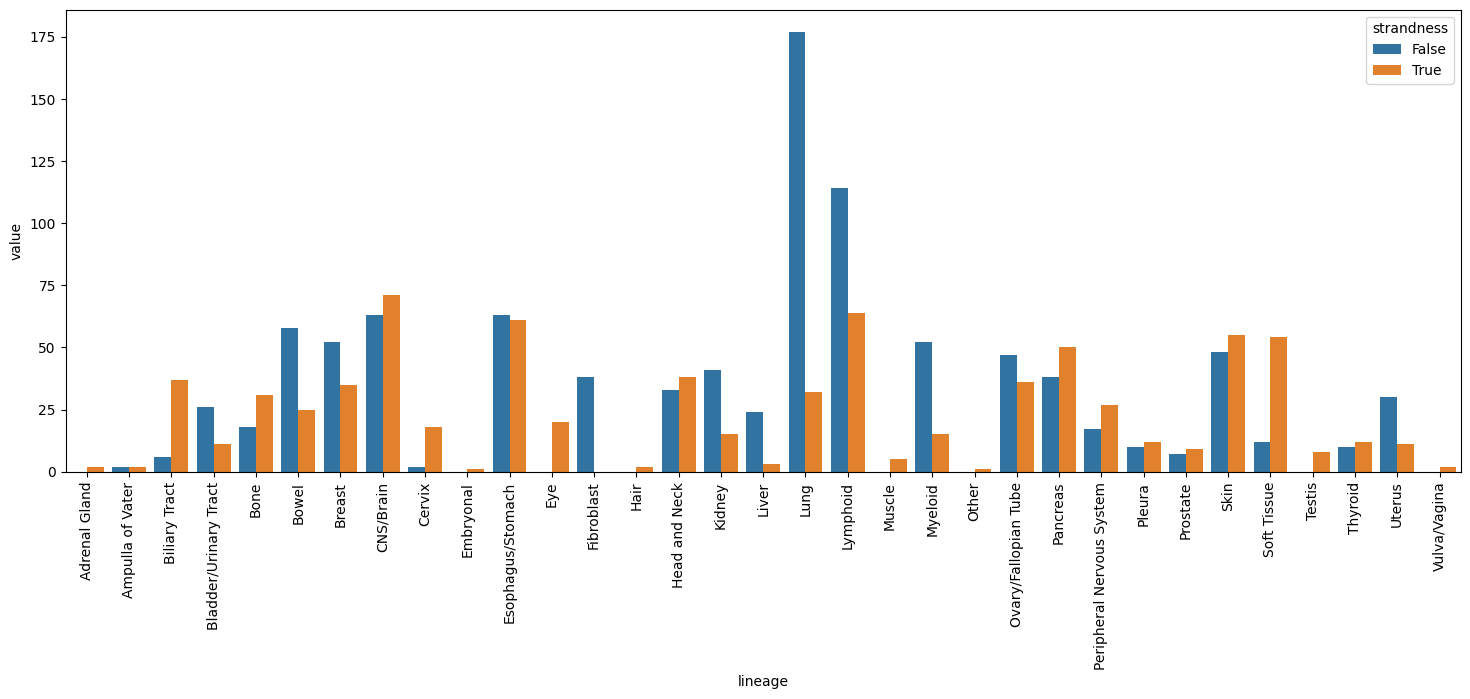

In [50]:
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')

profile_to_model_dict = OmicsDefaultModelProfiles.query("ProfileType == 'rna'").\
        set_index("ProfileID").\
        drop("ProfileType", axis=1).\
        to_dict()["ModelID"]

lineage = OmicsExpressionAllGenesTPMLogp1Profile.index.map(profile_to_model_dict).map(model_dataset.OncotreeLineage.to_dict())

pca_plot_data = pd.DataFrame({"lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
stat = pd.crosstab(pca_plot_data.iloc[:, 0], pca_plot_data.iloc[:, 1])
stat.melt(ignore_index=False).reset_index()

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
g = sns.barplot(data=stat.melt(ignore_index=False).reset_index(), x='lineage', y='value', hue='strandness')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [51]:
stat.loc[:, 'total'] = stat.sum(axis=1)

In [52]:
stat_sub = stat.copy()

In [53]:
stat_sub = stat_sub.apply(lambda x: x[:2]/ x[-1], axis=1)

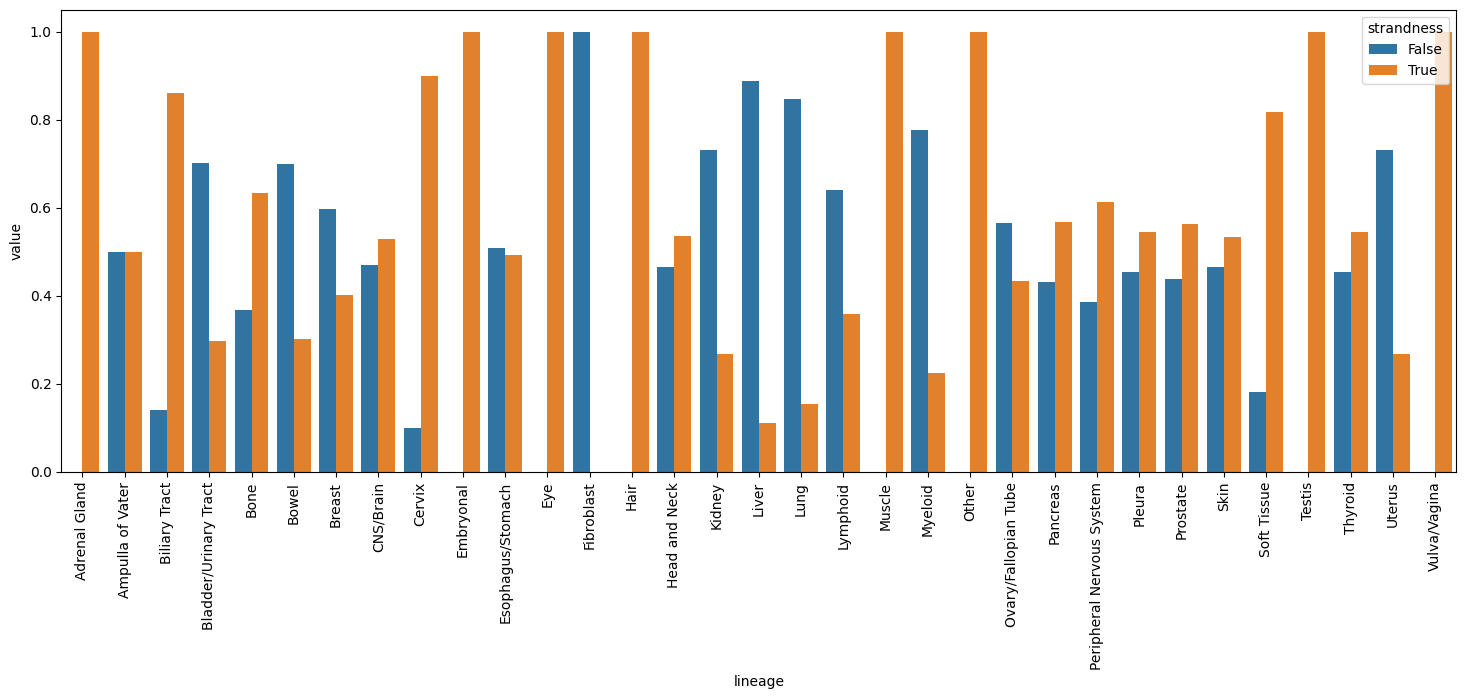

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
g = sns.barplot(data=stat_sub.melt(ignore_index=False).reset_index(), x='lineage', y='value', hue='strandness')
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

# All genes expression benchmarking

## Paired non-strand and strand rsem results comparison on the same sample

In [55]:
paired_data = dev_terra_rnaseq_df.loc[~dev_terra_rnaseq_df.rsem_genes_strandness.isnull(), 'rsem_genes_strandness'].reset_index().merge(
    terra_rnaseq_df.loc[:, ['rsem_genes']].reset_index(), on='sample_id')

475
263
195
247
283
208
530
320
337
257
302
334
313
301
311
347
305
420
281
279
352
303
275
299
416
241
328
309
295
247
288
361
437
212
342
333
601
252
300
326
411
308
332
368
283
238
282
322
413
300


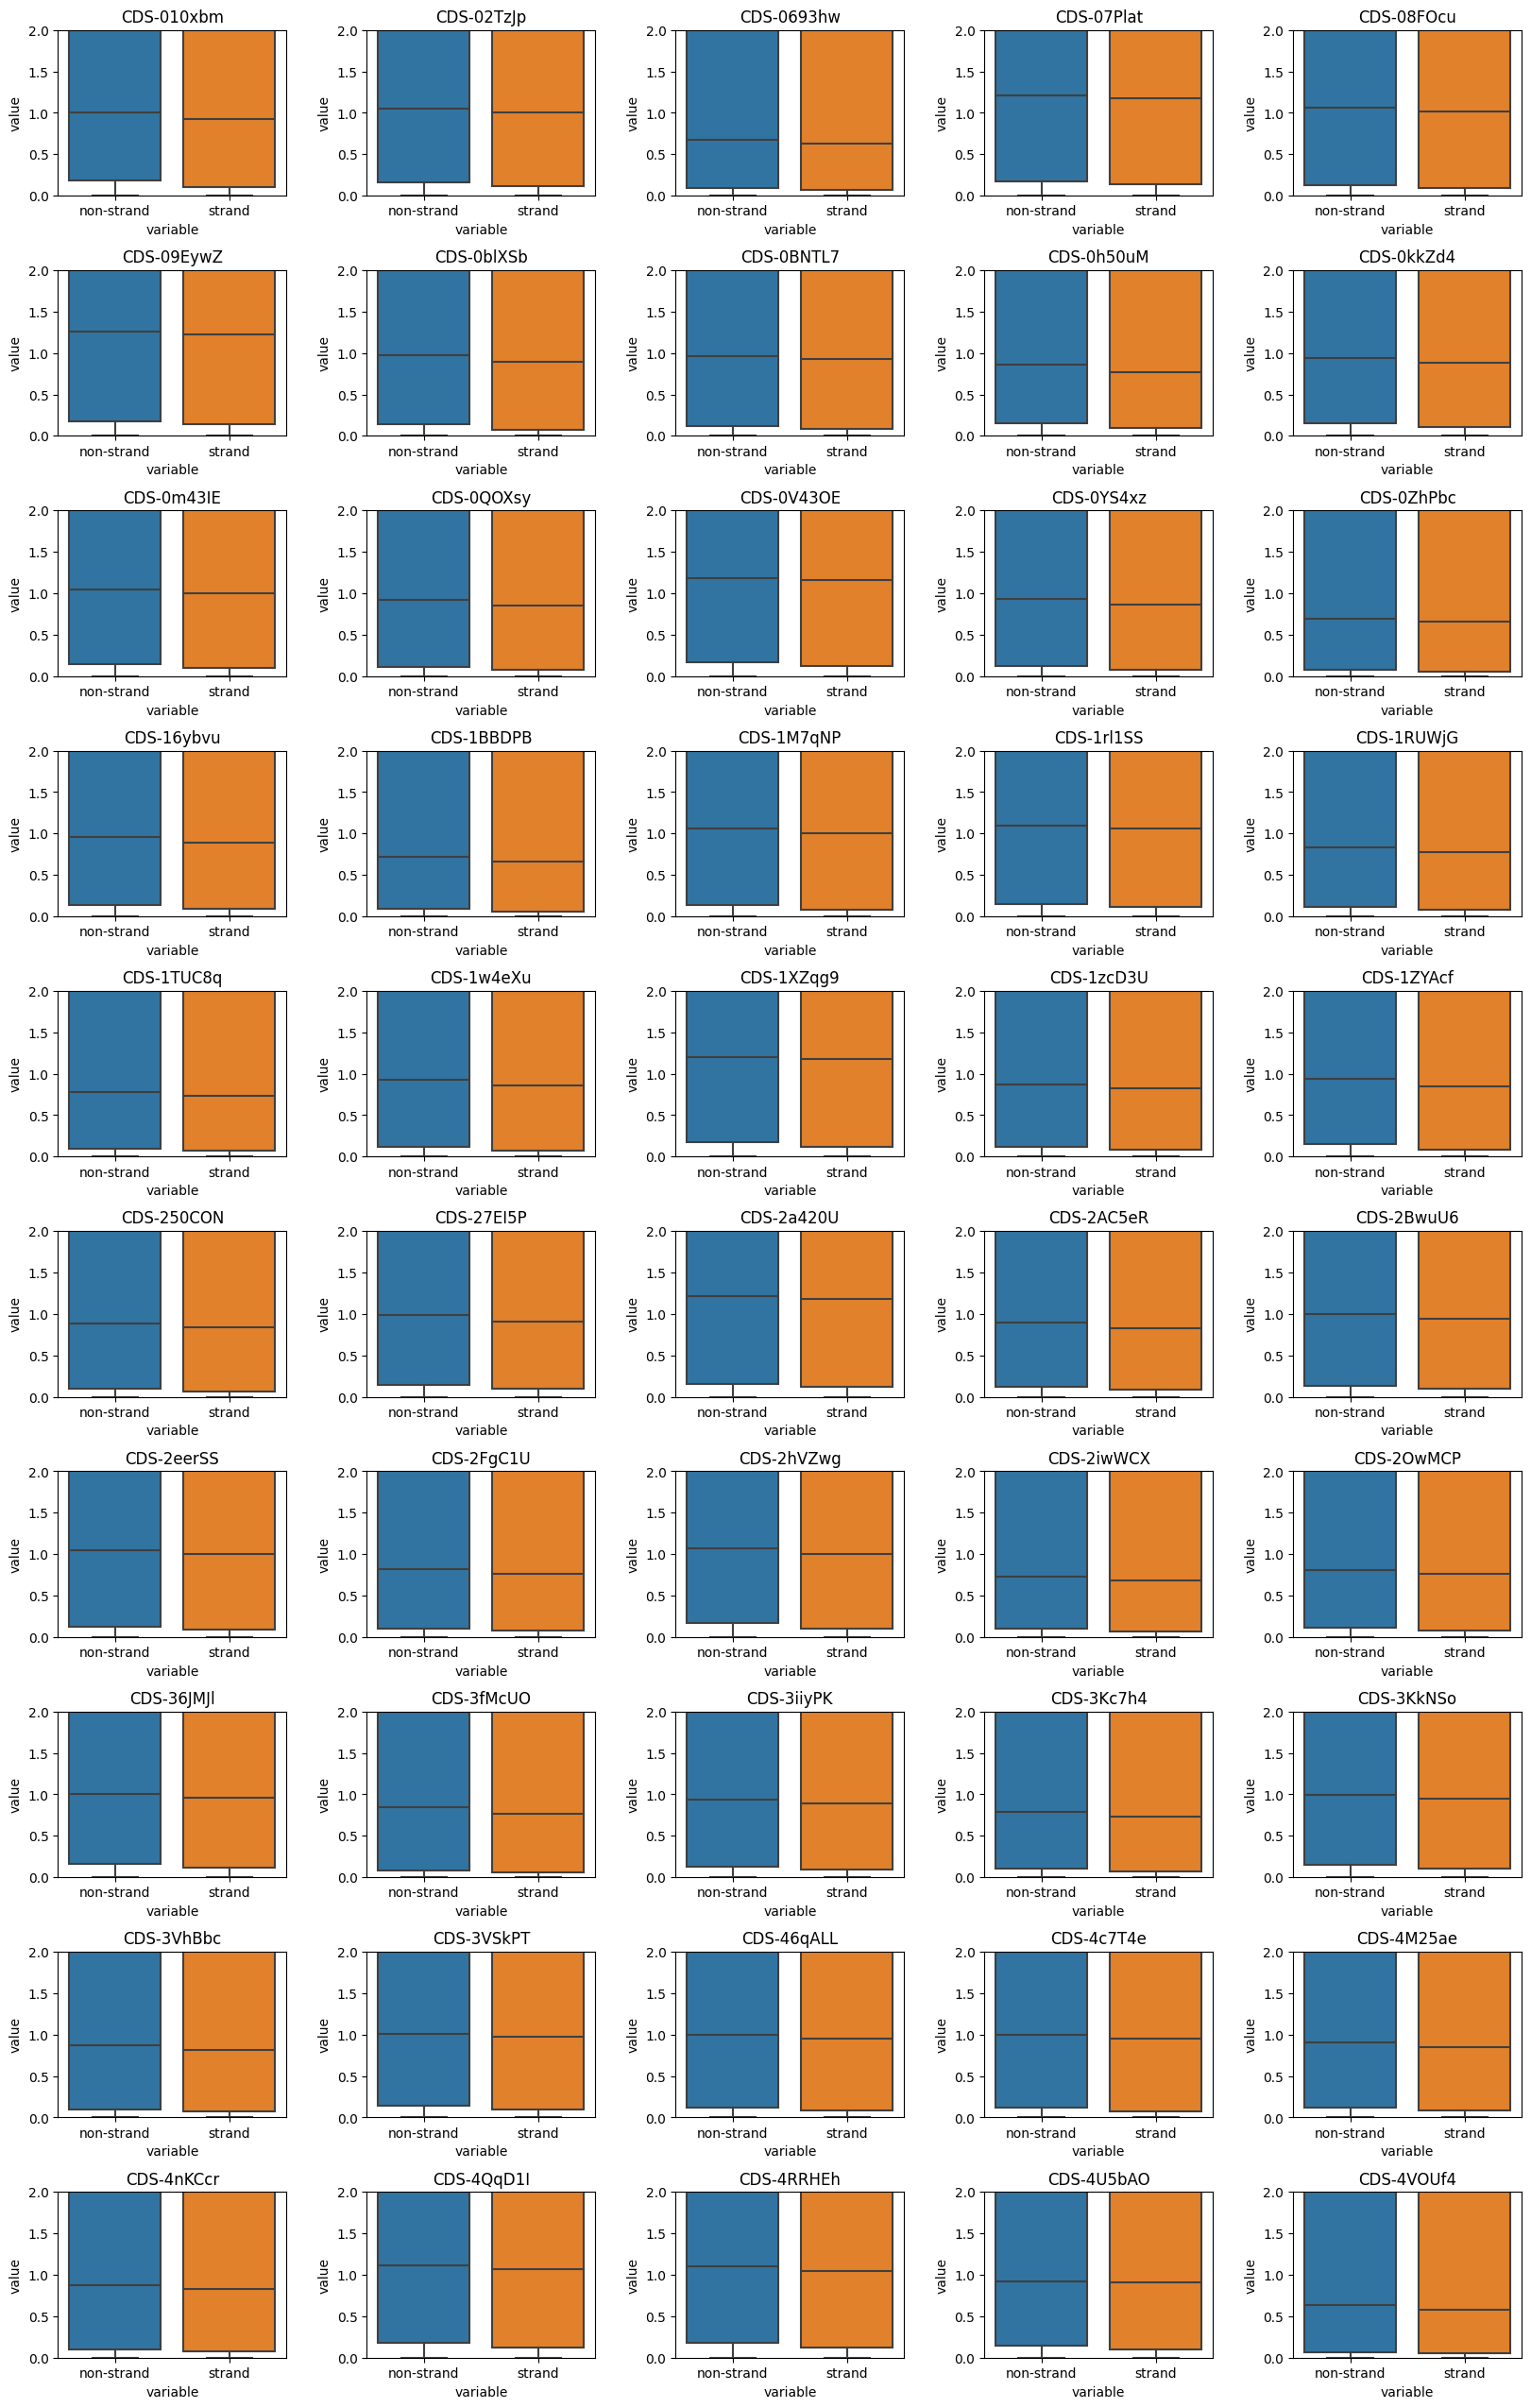

In [56]:
fig, ax = plt.subplots(10, 5)
fig.set_size_inches(20, 32)
ax = ax.flatten()
log2fc_all = []
union_prot_names = []

for row in range(50):
    df2 = pd.read_table(paired_data.iloc[row][2]).loc[:, ['gene_id', 'TPM']]
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']]
    df2.loc[:, 'TPM'] = np.log1p(df2.loc[:, 'TPM'])
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])

    merged_data = pd.merge(df2, df1, on='gene_id')
    merged_data.columns = ['sample_id', 'non-strand', 'strand']
    merged_data = merged_data.set_index("sample_id")
    #print(merged_data.head())

    merged_data = merged_data.loc[merged_data.sum(axis=1) != 0, :]
    log2fc = merged_data.iloc[:, 0] -  merged_data.iloc[:, 1]
    zero_change = sum((merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0))

    zero_prot = len(np.intersect1d(merged_data.index[(merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0)].map(lambda x:x.split('.')[0]),
                      protcod_ensem))
    print(zero_prot)

    union_prot_names += list(np.intersect1d(merged_data.index[(merged_data.iloc[:, 0] > 0) & ( merged_data.iloc[:, 1] == 0)].map(lambda x:x.split('.')[0]), protcod_ensem))
    log2fc_all.append([paired_data.iloc[row].sample_id, zero_change, zero_prot,
                       (log2fc>=1).sum(), (log2fc<=-1).sum(), merged_data.shape[0]])
    sns.boxplot(data=merged_data.melt(ignore_index=False), x='variable', y='value', ax=ax[row])
    #sns.kdeplot(data=merged_data, ax=ax[row])
    #plotting.density_scatter(merged_data.loc[:, 'non-strand'], merged_data.loc[:, 'strand'], ax=ax[row], s=3)
    ax[row].set_title(paired_data.iloc[row].sample_id)
    ax[row].set_ylim(0, 2)
fig.subplots_adjust(wspace=0.35, hspace=0.45)

In [57]:
union_prot_names = list(set(union_prot_names))

In [58]:
len(union_prot_names), len(protcod_ensem)

(3199, 21704)

In [59]:
len(union_prot_names) / len(protcod_ensem)

0.1473921857722079

In [60]:
log2fc_all = pd.DataFrame(log2fc_all)

In [62]:
log2fc_all.head()

0     1    2    3  4      5
0  CDS-010xbm  2868  475  297  6  26781
1  CDS-02TzJp  1630  263  173  7  24867
2  CDS-0693hw  1605  195  157  4  26754
3  CDS-07Plat  1309  247  154  7  22728
4  CDS-08FOcu  1475  283  143  5  22599

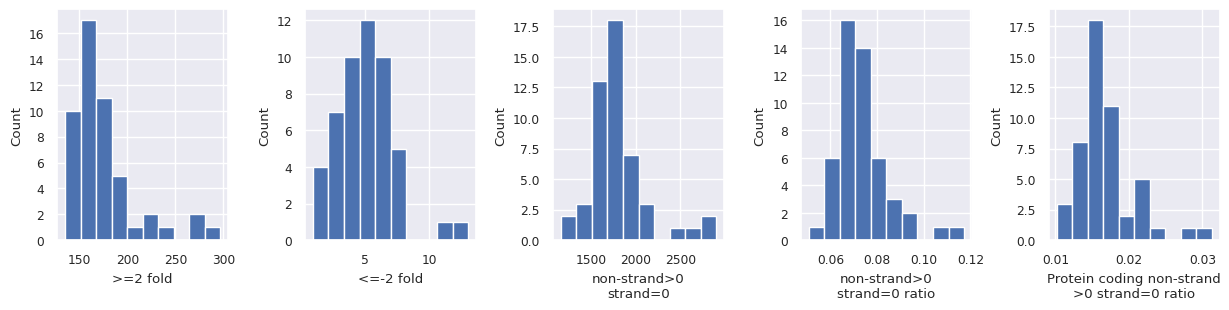

In [63]:
sns.set('talk')
sns.set(font_scale=0.8)  

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(15, 3)
ax[0].hist(log2fc_all.iloc[:, 3], bins=10)
ax[0].set_xlabel(">=2 fold")
ax[0].set_ylabel("Count")
ax[1].hist(log2fc_all.iloc[:, 4], bins=10)
ax[1].set_xlabel("<=-2 fold")
ax[1].set_ylabel("Count")

ax[2].hist(log2fc_all.iloc[:, 1], bins=10)
ax[2].set_xlabel("non-strand>0\nstrand=0")
ax[2].set_ylabel("Count")
ax[3].hist(log2fc_all.iloc[:, 1] / log2fc_all.iloc[:, 5], bins=10)
ax[3].set_xlabel("non-strand>0\nstrand=0 ratio")
ax[3].set_ylabel("Count")
ax[4].hist(log2fc_all.iloc[:, 2] / 19193, bins=10)
ax[4].set_xlabel("Protein coding non-strand\n>0 strand=0 ratio")
ax[4].set_ylabel("Count")
fig.subplots_adjust(wspace=0.45)

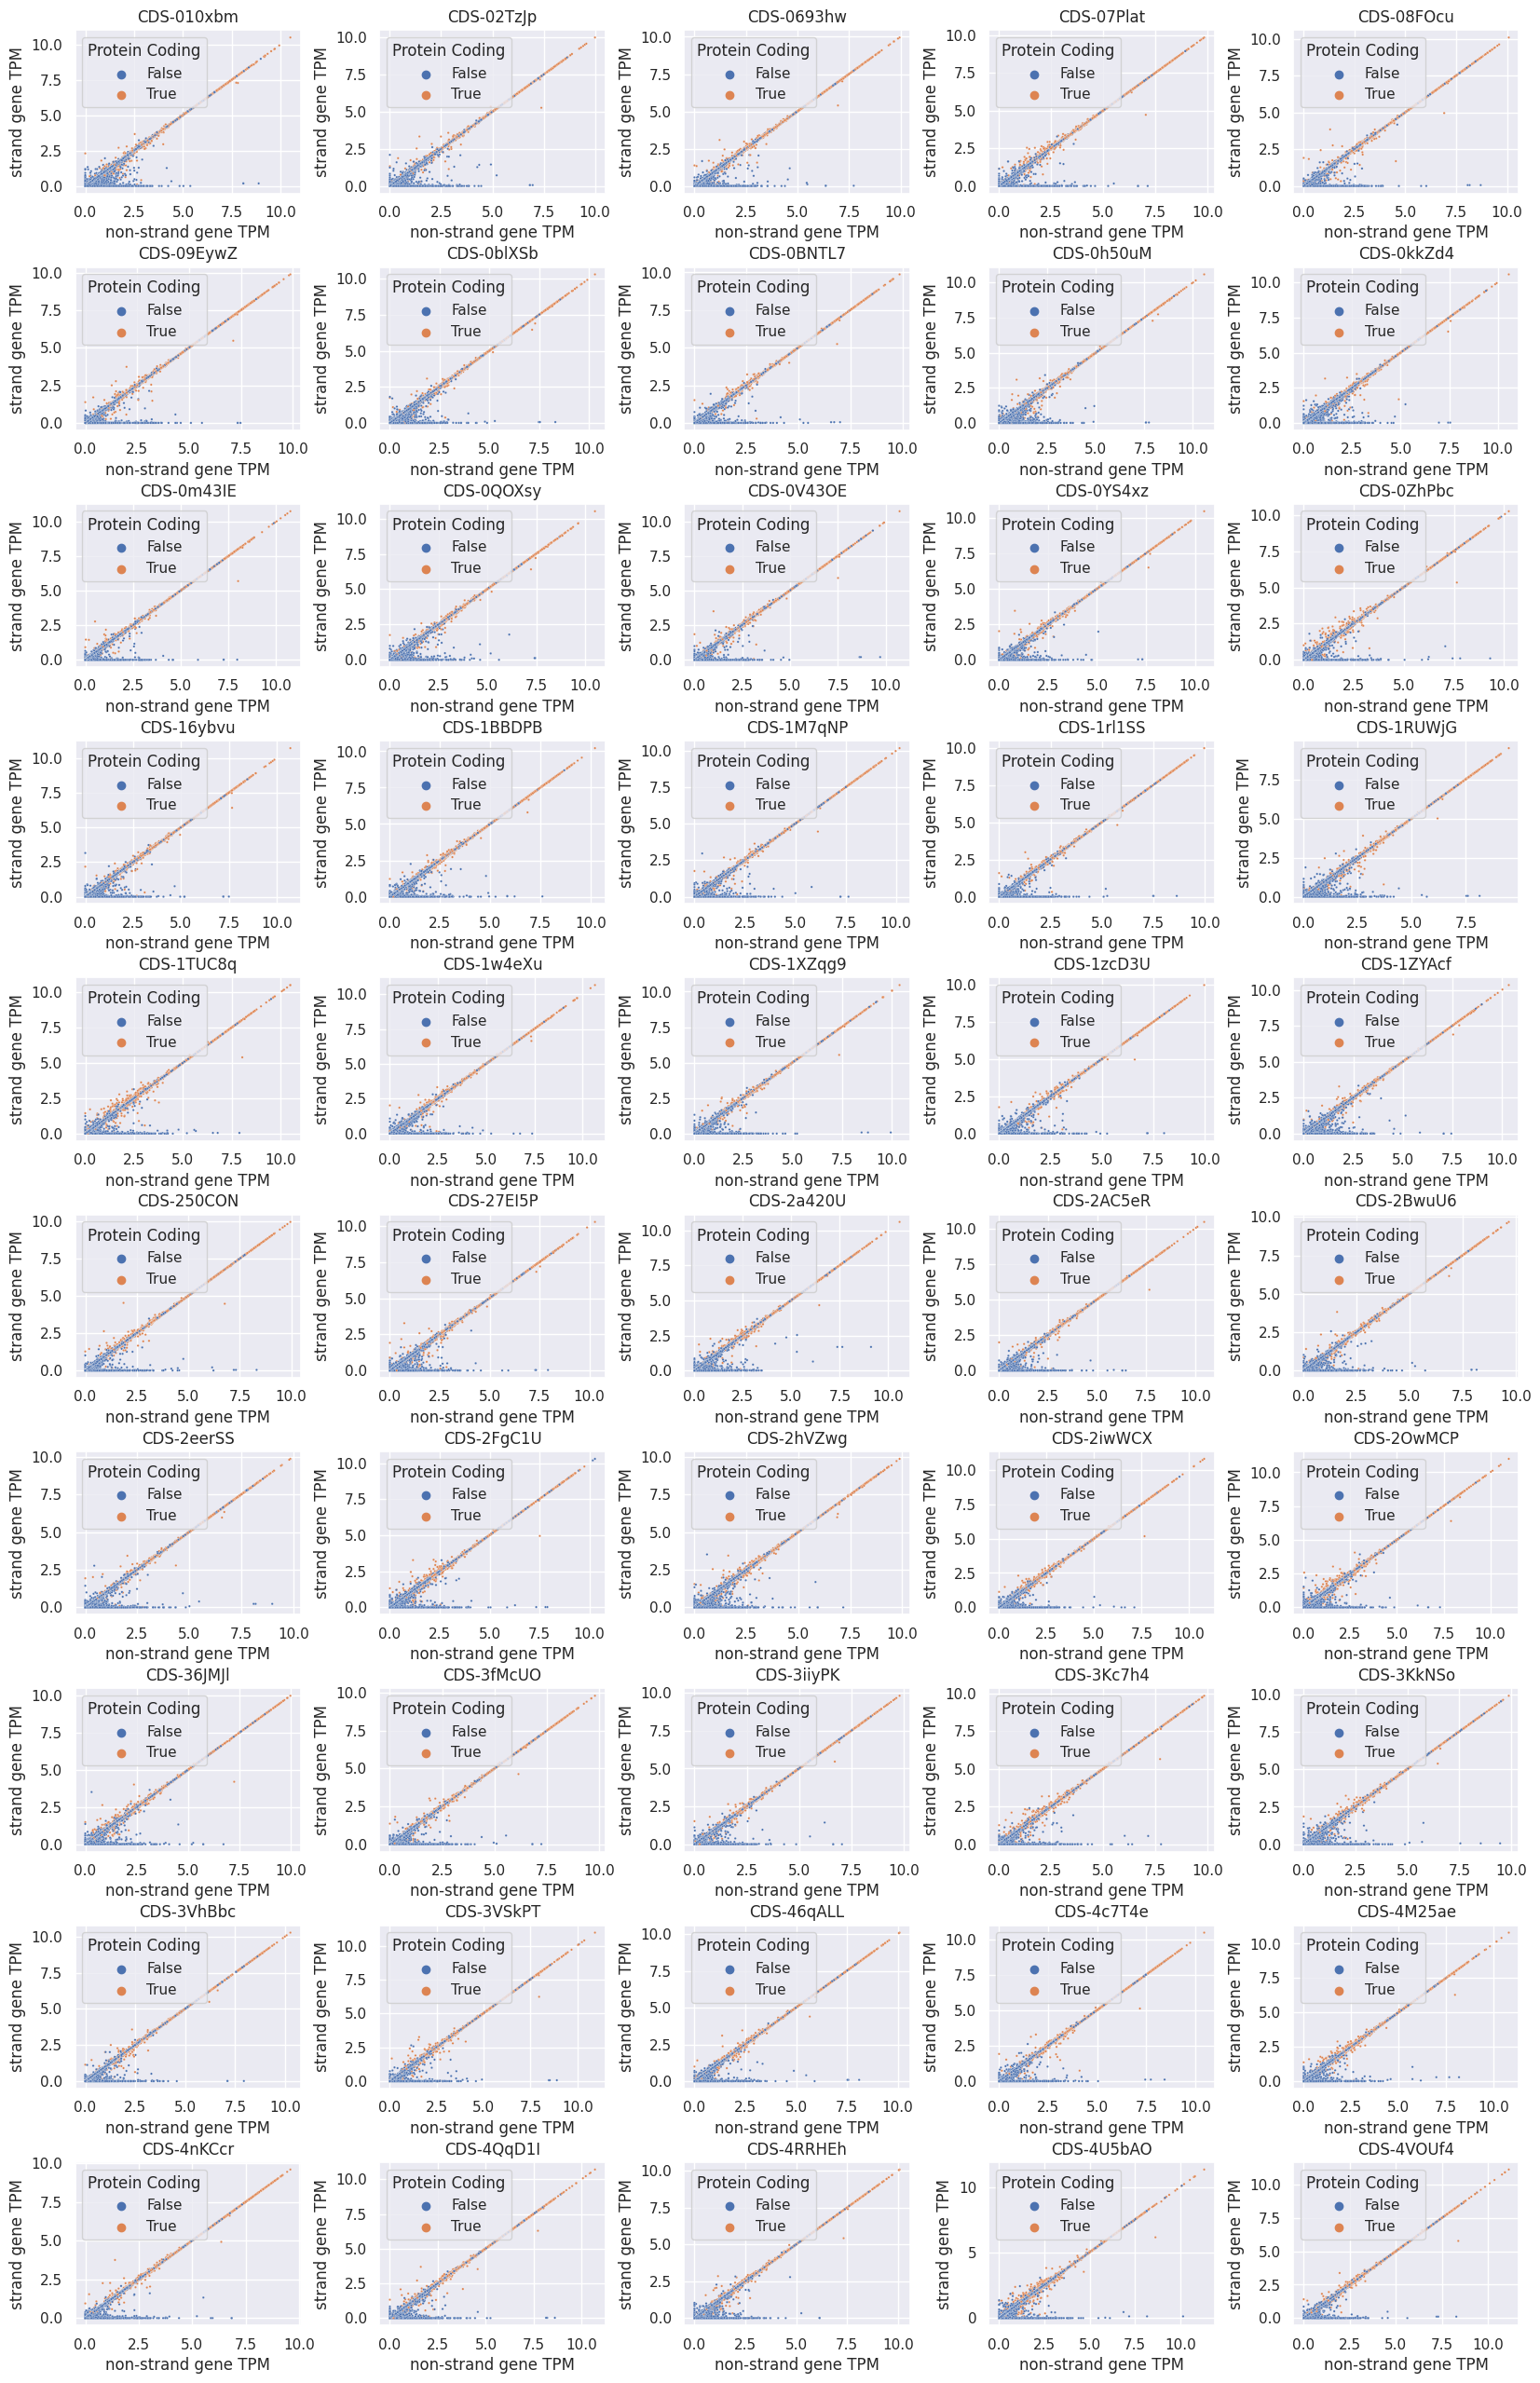

In [64]:
sns.set("talk")
sns.set(font_scale=1)  # crazy big

fig, ax = plt.subplots(10, 5)
fig.set_size_inches(20, 32)
ax = ax.flatten()
for row in range(50):
    df2 = pd.read_table(paired_data.iloc[row][2]).loc[:, ['gene_id', 'TPM']]
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']]
    df2.loc[:, 'TPM'] = np.log1p(df2.loc[:, 'TPM'])
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])

    merged_data = pd.merge(df2, df1, on='gene_id')
    merged_data.loc[:, 'proteincoding'] = merged_data.gene_id.map(lambda x:x.split('.')[0]).isin(protcod_ensem)
    #print(merged_data.loc[:, 'proteincoding'].sum())
    merged_data.columns = ['gene_id', 'non-strand gene TPM', 'strand gene TPM', 'Protein Coding']
    #print((merged_data.loc[:, 'strand gene TPM'] - merged_data.loc[:, 'non-strand gene TPM']).sort_values())
    sns.scatterplot(data=merged_data, x='non-strand gene TPM', y='strand gene TPM', hue='Protein Coding', ax=ax[row], s=3)
    #plotting.density_scatter(merged_data.loc[:, 'non-strand'], merged_data.loc[:, 'strand'], ax=ax[row], s=3)
    ax[row].set_title(paired_data.iloc[row].sample_id)

fig.subplots_adjust(wspace=0.35, hspace=0.45)

## PCA and UMAP comparison of two products

In [26]:
!pip install numpy==1.24

/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/mambaforge/envs/cds-omics/lib/python3.9/site-packag

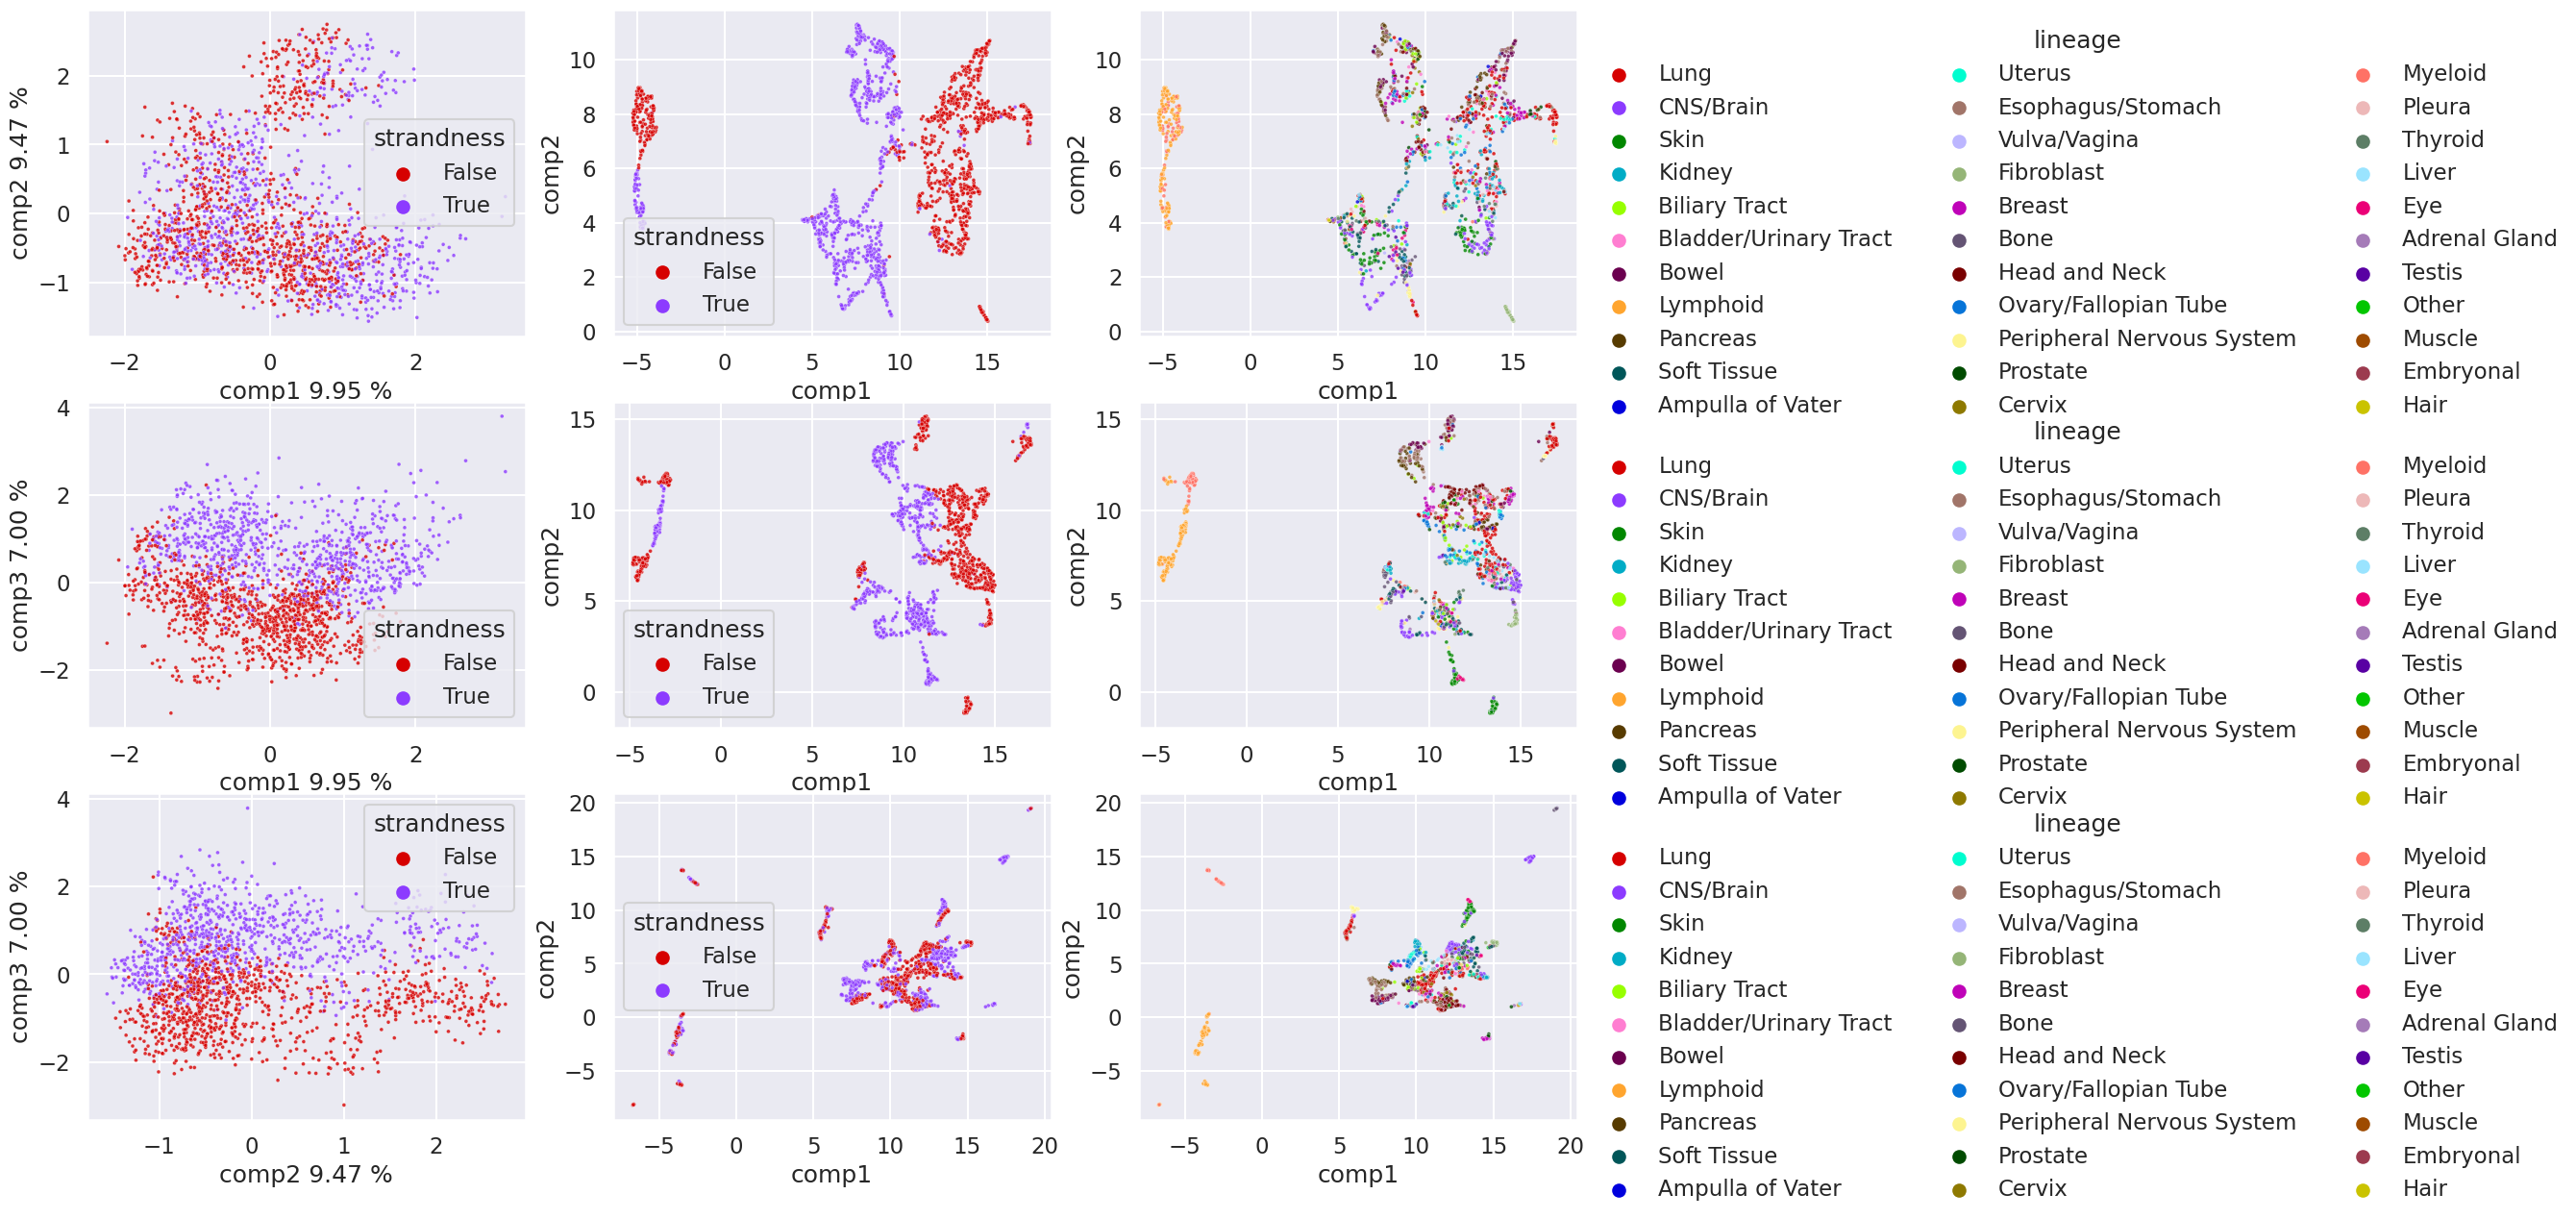

In [65]:
sns.set(font_scale=1.5)  # crazy big
sns.set("talk")

from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(20, 15)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(OmicsExpressionAllGenesTPMLogp1Profile)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)

## Add strand-specifc rsem results into the PCA/UMAP

In [66]:
df1s = []
for row in range(50):
    df1 = pd.read_table(paired_data.iloc[row][1]).loc[:, ['gene_id', 'TPM']].set_index("gene_id")
    df1.loc[:, 'TPM'] = np.log1p(df1.loc[:, 'TPM'])
    df1.columns = [paired_data.iloc[row][0]]
    df1s.append(df1)

In [67]:
df1s = pd.concat(df1s, axis=1)

In [68]:
df1s.head()

CDS-010xbm  CDS-02TzJp  CDS-0693hw  CDS-07Plat  \
gene_id                                                              
ENSG00000000003.15    3.022861    3.173878    2.190536    3.298426   
ENSG00000000005.6     0.000000    0.405465    0.000000    0.000000   
ENSG00000000419.14    5.124500    4.932962    5.121043    4.345492   
ENSG00000000457.14    1.991976    1.788421    1.662030    1.214913   
ENSG00000000460.17    3.117507    2.437990    2.943386    1.965713   

                    CDS-08FOcu  CDS-09EywZ  CDS-0blXSb  CDS-0BNTL7  \
gene_id                                                              
ENSG00000000003.15    2.954389    2.802754    4.108247    3.531055   
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000   
ENSG00000000419.14    3.952973    4.633660    4.713666    4.963054   
ENSG00000000457.14    1.456287    1.504077    2.303585    1.806648   
ENSG00000000460.17    1.128171    2.089392    2.143589    2.136531   

                    CDS-0h50uM  CDS-0kkZd4  ...  CDS-3VhBbc  CDS-3VSkPT  \
gene_id                                     ...                           
ENSG00000000003.15    3.080073    1.444563  ...    0.000000    0.425268   
ENSG00000000005.6     0.322083    0.000000  ...    0.000000    0.000000   
ENSG00000000419.14    5.119908    4.586395  ...    3.666634    3.701055   
ENSG00000000457.14    1.566530    1.662030  ...    1.978239    1.418277   
ENSG00000000460.17    2.877512    2.845491  ...    1.990610    1.481605   

                    CDS-46qALL  CDS-4c7T4e  CDS-4M25ae  CDS-4nKCcr  \
gene_id                                                              
ENSG00000000003.15    3.335414    3.448717    2.639057    2.471484   
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000   
ENSG00000000419.14    4.786241    4.371724    4.367420    5.148134   
ENSG00000000457.14    1.595339    1.488400    1.252763    1.423108   
ENSG00000000460.17    1.974081    2.783776    2.140066    2.930660   

                    CDS-4QqD1I  CDS-4RRHEh  CDS-4U5bAO  CDS-4VOUf4  
gene_id                                                             
ENSG00000000003.15    2.321407    3.003204    2.826722    3.120160  
ENSG00000000005.6     0.000000    0.000000    0.000000    0.000000  
ENSG00000000419.14    4.427836    5.003544    3.128513    4.452369  
ENSG00000000457.14    1.007958    1.675226    1.451614    1.638997  
ENSG00000000460.17    2.422144    3.172203    1.528228    1.830980  

[5 rows x 50 columns]

In [69]:
gene_ids = df1s.index.map(lambda x:x.split('.')[0]).map(allgenes_rename).values
gene_ids[pd.isnull(gene_ids)] = df1s.index[pd.isnull(gene_ids)].map(lambda x:x.split('.')[0])

In [70]:
gene_ids.shape

(60649,)

In [71]:
df1s.index = gene_ids
df1s = df1s.T

In [73]:
df1s_sub = df1s.loc[:, df1s.loc[:, OmicsExpressionAllGenesTPMLogp1Profile.columns].columns.unique()].copy()

In [75]:
df1s_sub.shape

(50, 54002)

In [76]:
df1s_sub = df1s_sub.loc[:, ~df1s_sub.columns.duplicated()]

In [39]:
#dict(zip(meta.MainSequencingID, meta.ProfileID))

In [77]:
all_include_stranded = pd.concat([OmicsExpressionAllGenesTPMLogp1Profile, df1s_sub], axis=0)

In [41]:
### lineage = OmicsExpressionAllGenesTPMLogp1Profile.index.map(profile_to_model_dict).map(model_dataset.OncotreeLineage.to_dict())

(1954,) (1954, 5)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:21: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 10)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:24: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 30)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:27: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/570636341.py:33: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


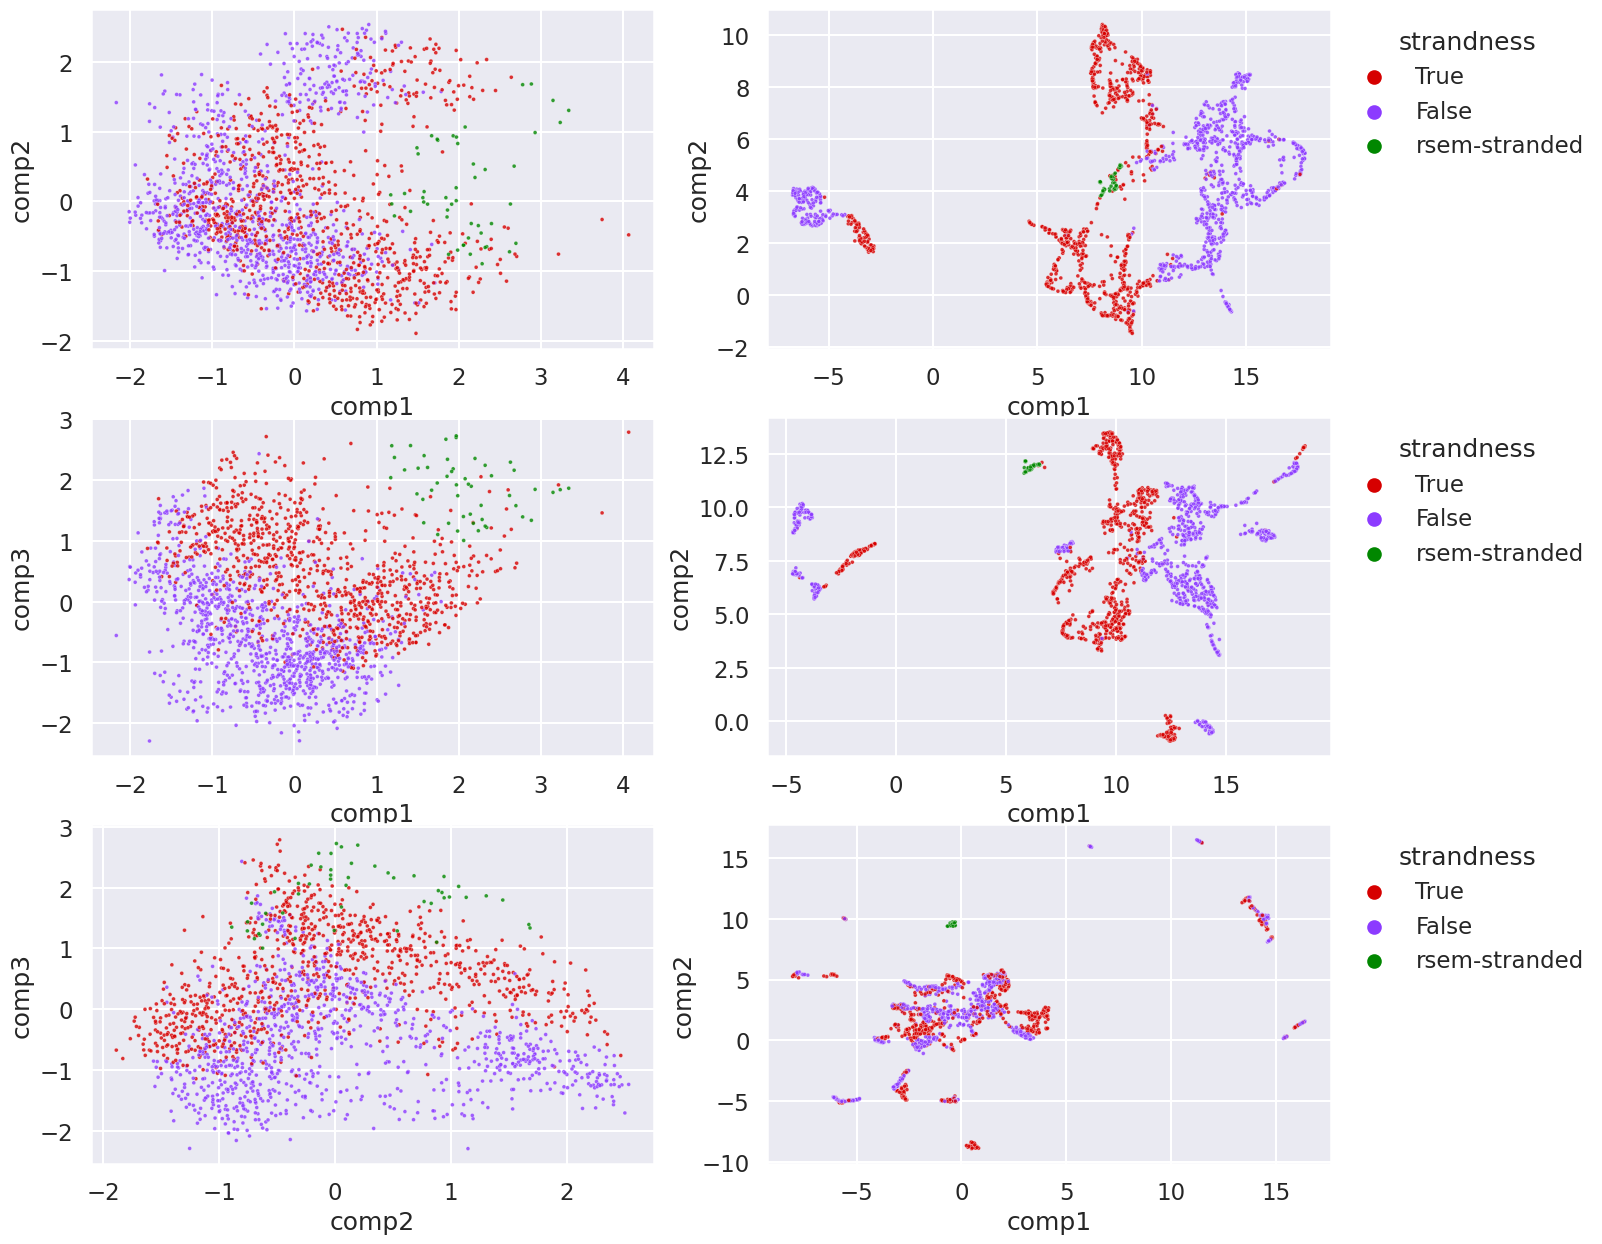

In [78]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(16, 15)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(all_include_stranded)
    strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*50])
    print(strandness.shape, components.shape)
 
    #pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], 
    #                              "strandness": strandness})
    #sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1],
                                  "strandness": strandness})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    sns.move_legend(ax[i][1], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=1)

# Protein coding genes impact

In [79]:
OmicsExpressionAllGenesTPMLogp1Profile.columns = OmicsExpressionAllGenesTPMLogp1Profile.columns.map(protcod_rename)
OmicsExpressionAllGenesTPMLogp1Profile = OmicsExpressionAllGenesTPMLogp1Profile.loc[:, ~OmicsExpressionAllGenesTPMLogp1Profile.columns.isnull()]

In [80]:
OmicsExpressionAllGenesTPMLogp1Profile.shape

(1904, 19193)

In [81]:
OmicsExpressionAllGenesTPMLogp1Profile.columns

Index(['TSPAN6 (7105)', 'TNMD (64102)', 'DPM1 (8813)', 'SCYL3 (57147)',
       'C1orf112 (55732)', 'FGR (2268)', 'CFH (3075)', 'FUCA2 (2519)',
       'GCLC (2729)', 'NFYA (4800)',
       ...
       'H3C2 (8358)', 'H3C3 (8352)', 'AC098582.1 (8916)',
       'DUS4L-BCAP29 (115253422)', 'C8orf44-SGK3 (100533105)',
       'ELOA3B (728929)', 'NPBWR1 (2831)', 'ELOA3D (100506888)',
       'ELOA3 (162699)', 'CDR1 (1038)'],
      dtype='object', length=19193)

In [82]:
all_include_stranded.columns = all_include_stranded.columns.map(protcod_rename)
all_include_stranded = all_include_stranded.loc[:, ~all_include_stranded.columns.isnull()]

In [83]:
all_include_stranded.shape

(1954, 19193)

In [84]:
all_include_stranded.head()

TSPAN6 (7105)  TNMD (64102)  DPM1 (8813)  SCYL3 (57147)  \
PR-AdBjpG       4.331992      0.000000     7.364660       2.792855   
PR-I2AzwG       4.567424      0.584963     7.106641       2.543496   
PR-5ekAAC       3.150560      0.000000     7.379118       2.333424   
PR-DuAy1L       4.240314      0.000000     5.681168       2.063503   
PR-pGHJuj       4.032101      0.000000     6.674687       2.117695   

           C1orf112 (55732)  FGR (2268)  CFH (3075)  FUCA2 (2519)  \
PR-AdBjpG          4.471187    0.028569    1.226509      3.044394   
PR-I2AzwG          3.504620    0.000000    0.189034      3.813525   
PR-5ekAAC          4.228049    0.056584    1.310340      6.687201   
PR-DuAy1L          1.641546    0.000000    7.236301      5.948367   
PR-pGHJuj          3.003602    0.000000    2.169925      6.838195   

           GCLC (2729)  NFYA (4800)  ...  H3C2 (8358)  H3C3 (8352)  \
PR-AdBjpG     6.500005     4.739848  ...     2.689299     0.189034   
PR-I2AzwG     4.221877     3.481557  ...     1.286881     1.049631   
PR-5ekAAC     3.682573     3.273516  ...     0.594549     1.097611   
PR-DuAy1L     4.596935     2.918386  ...     0.000000     0.000000   
PR-pGHJuj     3.253989     4.276497  ...     0.238787     0.378512   

           AC098582.1 (8916)  DUS4L-BCAP29 (115253422)  \
PR-AdBjpG           0.201634                  2.130931   
PR-I2AzwG           0.321928                  1.464668   
PR-5ekAAC           0.831877                  2.946731   
PR-DuAy1L           0.847997                  1.887525   
PR-pGHJuj           0.584963                  1.748461   

           C8orf44-SGK3 (100533105)  ELOA3B (728929)  NPBWR1 (2831)  \
PR-AdBjpG                  0.555816              0.0       0.275007   
PR-I2AzwG                  0.632268              0.0       0.014355   
PR-5ekAAC                  0.475085              0.0       0.084064   
PR-DuAy1L                  0.176323              0.0       0.000000   
PR-pGHJuj                  0.839960              0.0       0.014355   

           ELOA3D (100506888)  ELOA3 (162699)  CDR1 (1038)  
PR-AdBjpG                 0.0             0.0     0.000000  
PR-I2AzwG                 0.0             0.0     0.000000  
PR-5ekAAC                 0.0             0.0     0.042644  
PR-DuAy1L                 0.0             0.0     0.000000  
PR-pGHJuj                 0.0             0.0     0.042644  

[5 rows x 19193 columns]

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/495040070.py:16: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/495040070.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/495040070.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/495040070.py:33: UserWarning: The palette list h

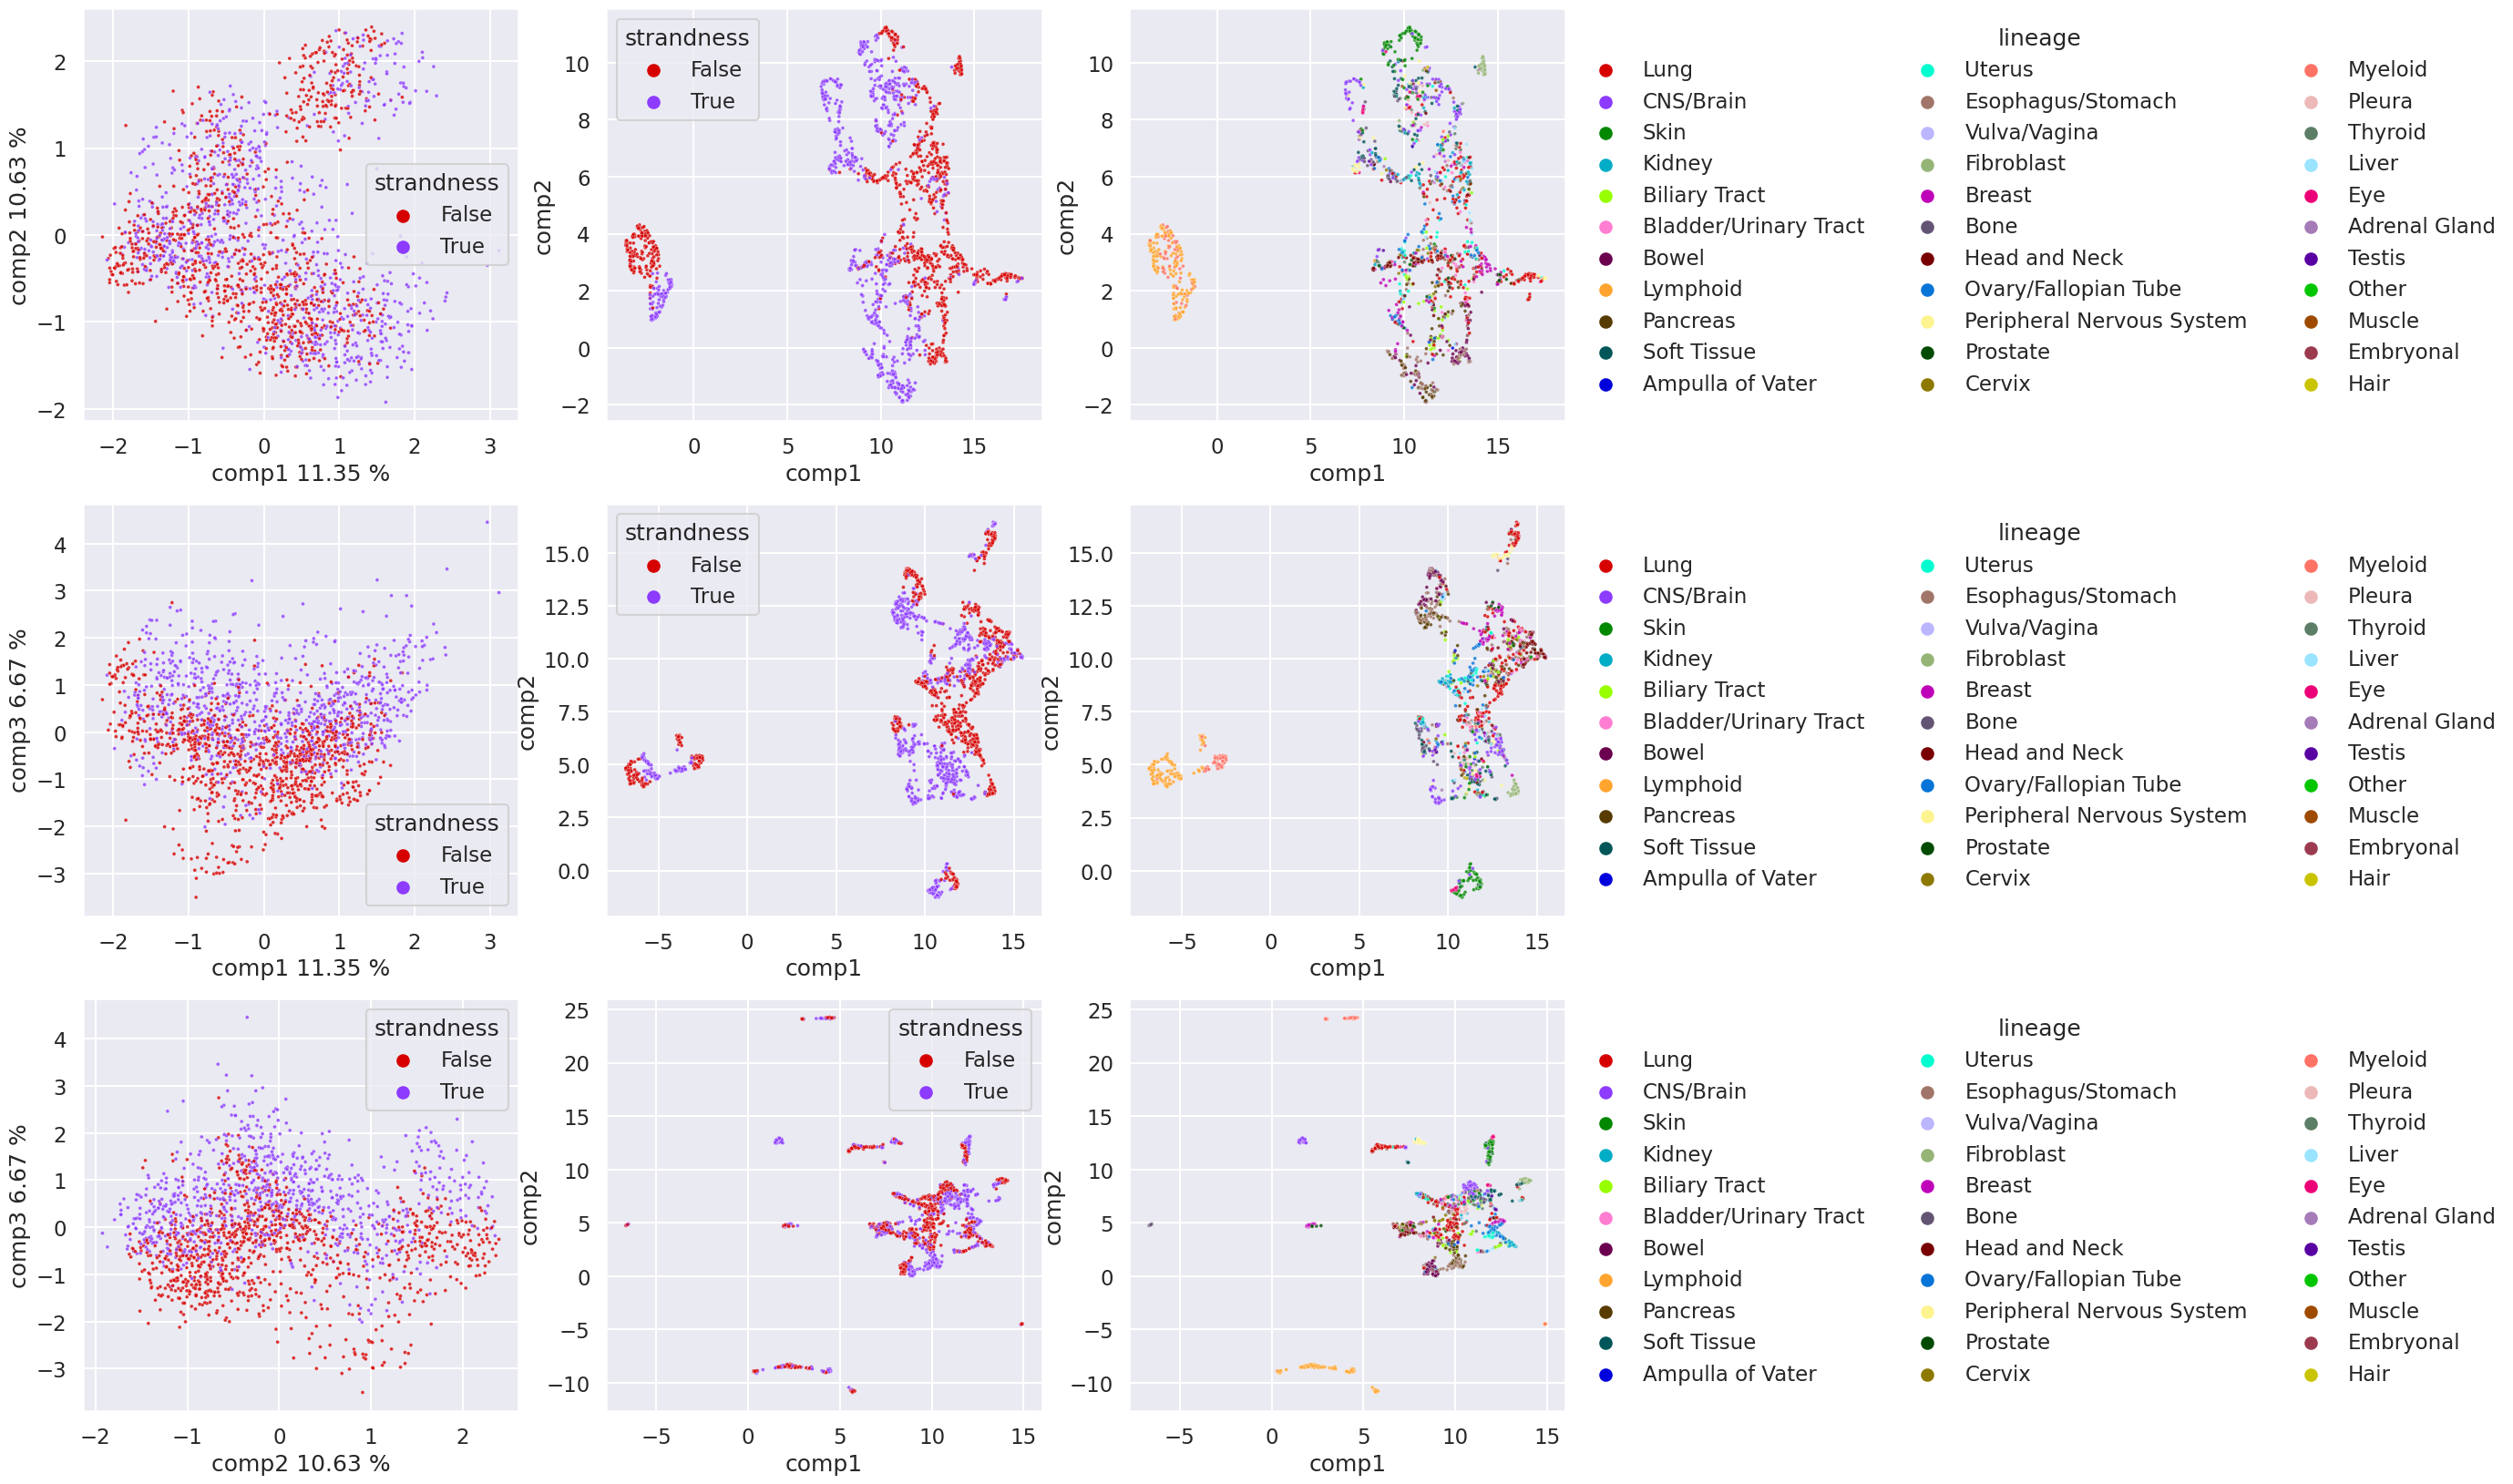

In [85]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(OmicsExpressionAllGenesTPMLogp1Profile)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


(1954,) (1954, 5)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:22: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 10)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:25: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


(1954,) (1954, 30)


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:28: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1115644382.py:34: UserWarning: The palette list has more values (33) than needed (3), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)


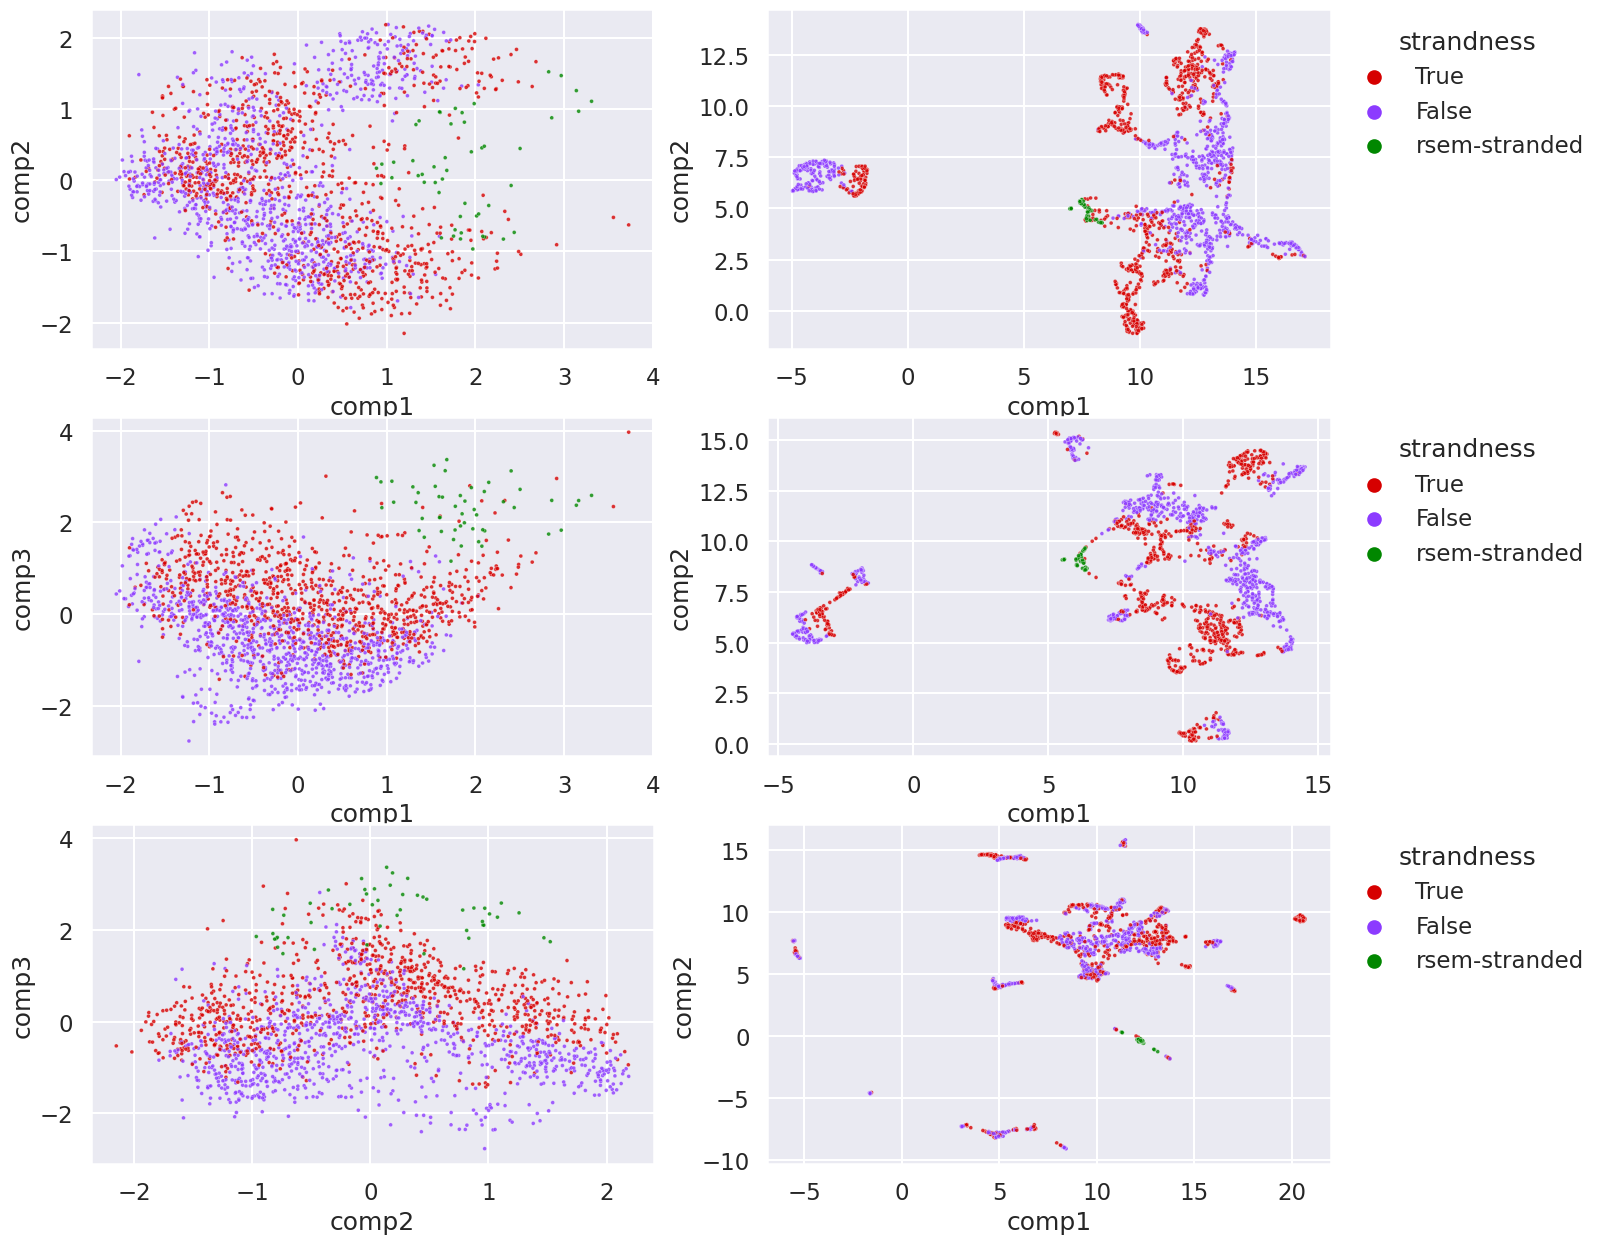

In [86]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(16, 15)


for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(all_include_stranded)
    strandness = np.hstack([OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness']))), ['rsem-stranded']*50])
    print(strandness.shape, components.shape)
 
    #pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], 
    #                              "strandness": strandness})
    #sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "strandness": strandness})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette, legend=False)
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1],
                                  "strandness": strandness})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    sns.move_legend(ax[i][1], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=1)


In [35]:
from inmoose.pycombat import pycombat_norm, pycombat_seq


In [88]:
strandness = OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))
tpm_corrected = pycombat_norm(OmicsExpressionAllGenesTPMLogp1Profile.T, strandness)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [89]:
tpm_corrected.shape

(19193, 1904)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1375715610.py:16: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1375715610.py:33: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/1375715610.py:21: UserWarning: The palette list has more values (33) than needed (2), which may not be intended.
  sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)

[WARNING] /home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_9088/13

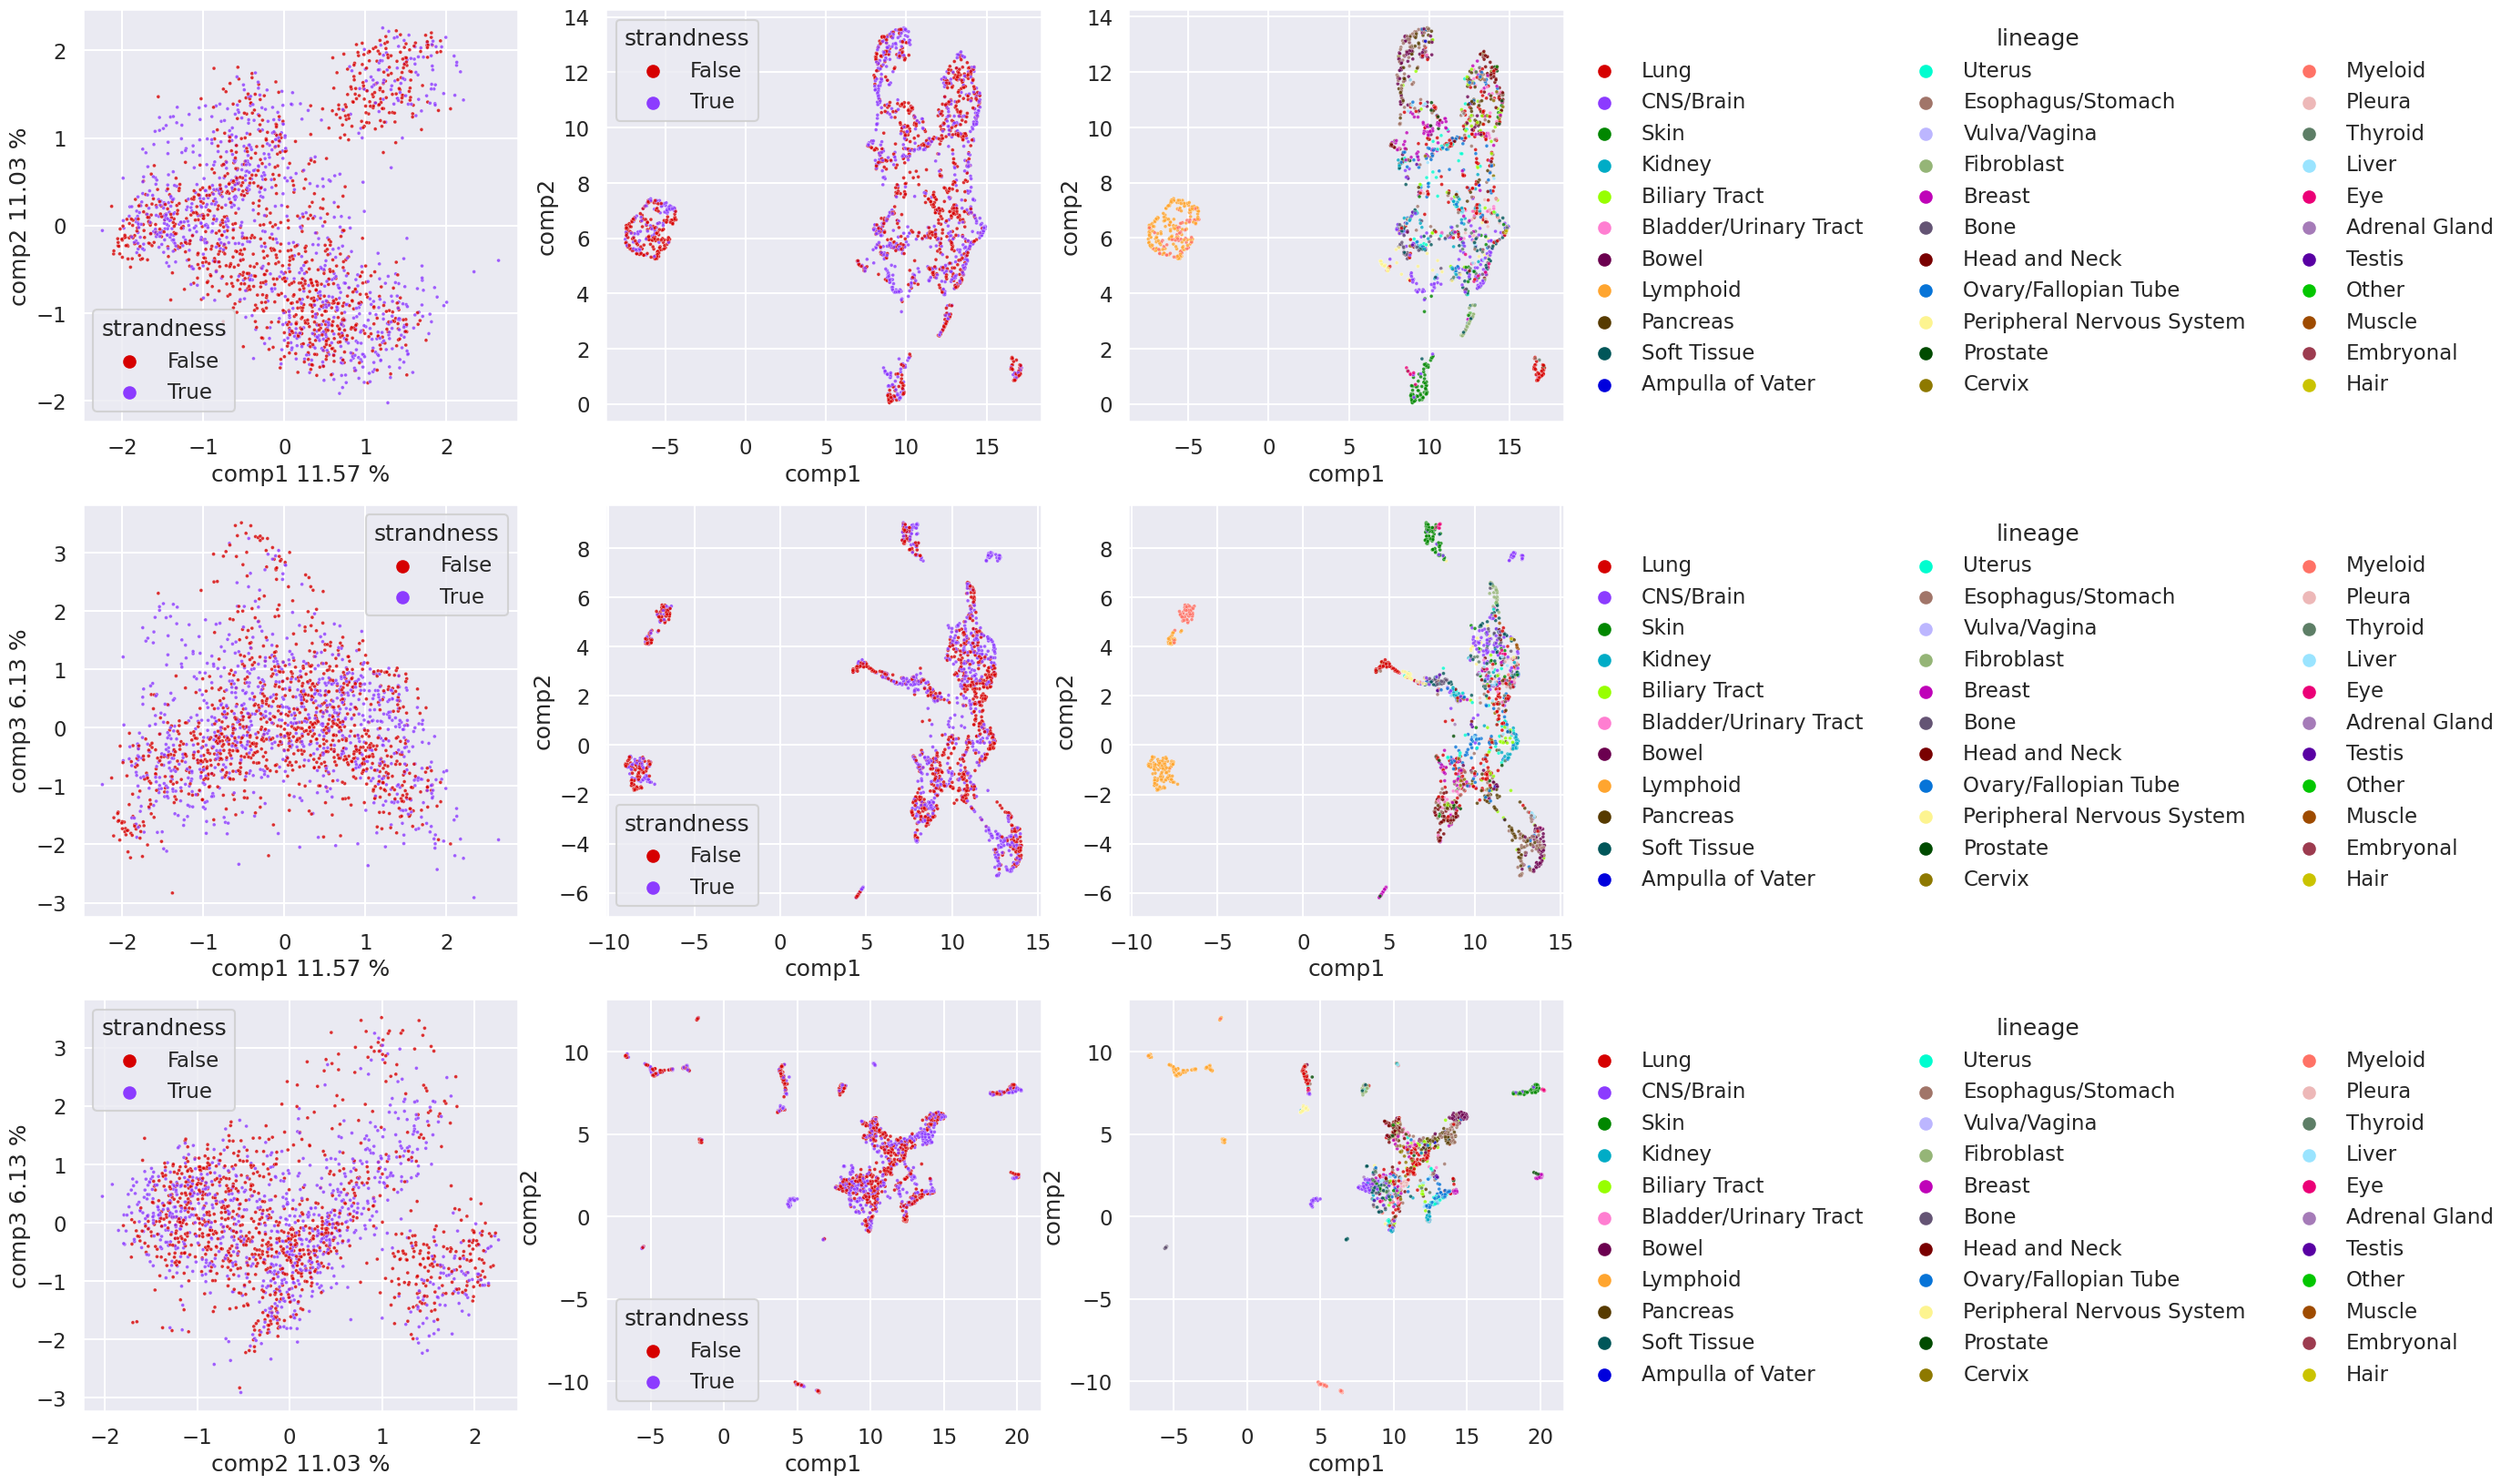

In [91]:
from sklearn.decomposition import PCA
import pandas as pd
import colorcet as cc
import umap
u = umap.UMAP()
palette = sns.color_palette(cc.glasbey, n_colors=33)

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(21, 20)

for i, comp_number in enumerate([5, 10, 30]):
    pca = PCA(n_components=comp_number, whiten=True, random_state=999)
    components = pca.fit_transform(tpm_corrected.T)
    if i == 0:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp2": components[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
    elif i == 1:
        pca_plot_data = pd.DataFrame({"comp1": components[:, 0], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp1", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp1 {pca.explained_variance_ratio_[0]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    elif i == 2:
        pca_plot_data = pd.DataFrame({"comp2": components[:, 1], "comp3": components[:, 2], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
        sns.scatterplot(data=pca_plot_data, x="comp2", y="comp3", hue="strandness", alpha=0.8, s=8, ax=ax[i][0], palette=palette)
        ax[i][0].set_xlabel(f'comp2 {pca.explained_variance_ratio_[1]*100:.2f} %')
        ax[i][0].set_ylabel(f'comp3 {pca.explained_variance_ratio_[2]*100:.2f} %')
    
    umap_rna = u.fit_transform(components)
    
    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="strandness", alpha=0.8, s=8, ax=ax[i][1], palette=palette)

    pca_plot_data = pd.DataFrame({"comp1": umap_rna[:, 0], "comp2": umap_rna[:, 1], "lineage": lineage, "strandness": OmicsExpressionAllGenesTPMLogp1Profile.index.map(dict(zip(strand_count_dfs.Profile, strand_count_dfs.loc[:, 'strandness'])))})
    sns.scatterplot(data=pca_plot_data, x="comp1", y="comp2", hue="lineage", alpha=0.8, s=8, ax=ax[i][2], palette=palette)
    sns.move_legend(ax[i][2], "upper left", bbox_to_anchor=(1, 1), frameon=False, ncols=3)


In [17]:
OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [29]:
strand_count_dfs_sub = strand_count_dfs.loc[~strand_count_dfs.model_id.isnull(), :]

In [30]:
strand_count_dfs_sub.head()

0           Fraction of reads failed to determine  \
sample_id                                           
CDS-010xbm                                 0.0259   
CDS-02TzJp                                 0.0301   
CDS-04NSe4                                 0.0135   
CDS-0693hw                                 0.0142   
CDS-08FOcu                                 0.0289   

0           Fraction of reads explained by "1++,1--,2+-,2-+"  \
sample_id                                                      
CDS-010xbm                                            0.0212   
CDS-02TzJp                                            0.0153   
CDS-04NSe4                                            0.0304   
CDS-0693hw                                            0.0101   
CDS-08FOcu                                            0.0127   

0           Fraction of reads explained by "1+-,1-+,2++,2--"    Profile  \
sample_id                                                                 
CDS-010xbm                                            0.9528  PR-AdBjpG   
CDS-02TzJp                                            0.9546  PR-I2AzwG   
CDS-04NSe4                                            0.9560  PR-iQmzF3   
CDS-0693hw                                            0.9757  PR-5ekAAC   
CDS-08FOcu                                            0.9584  PR-DuAy1L   

0             model_id  strandness  
sample_id                           
CDS-010xbm  ACH-001113        True  
CDS-02TzJp  ACH-001289        True  
CDS-04NSe4  ACH-003062        True  
CDS-0693hw  ACH-001339        True  
CDS-08FOcu  ACH-001979        True

In [31]:
OmicsExpressionProteinCodingGenesTPMLogp1.index[~OmicsExpressionProteinCodingGenesTPMLogp1.index.isin(strand_count_dfs_sub.model_id)]

Index(['ACH-001429'], dtype='object')

In [32]:
strand_dict = strand_count_dfs_sub.set_index('model_id').strandness.to_dict()

In [33]:
strand_dict['ACH-001429'] = True

In [36]:
strandness = OmicsExpressionProteinCodingGenesTPMLogp1.index.map(strand_dict)
tpm_corrected = pycombat_norm(OmicsExpressionProteinCodingGenesTPMLogp1.T, strandness)

[INFO] Found 2 batches
[INFO] Adjusting for 0 covariate(s) or covariate level(s)
[INFO] Standardizing Data across genes.


[INFO] Fitting L/S model and finding priors.
[INFO] Finding parametric adjustments.
[INFO] Adjusting the Data


In [37]:
tpm_corrected.head()

ACH-001113  ACH-001289  ACH-001339  ACH-001979  ACH-002438  \
TSPAN6 (7105)       4.097754    4.338188    2.891222    4.004129    3.791492   
TNMD (64102)       -0.017043    0.423591   -0.017043   -0.017043   -0.017043   
DPM1 (8813)         7.201221    6.970612    7.214143    5.696571    6.584545   
SCYL3 (57147)       2.861077    2.613768    2.405424    2.137724    2.191470   
C1orf112 (55732)    4.580335    3.723744    4.364861    2.072652    3.279732   

                  ACH-001538  ACH-000242  ACH-000708  ACH-000327  ACH-000233  \
TSPAN6 (7105)       4.867107    6.883762    4.470487    3.551937    0.328738   
TNMD (64102)       -0.017043    0.016951    0.346205    0.016951    0.016951   
DPM1 (8813)         7.013128    6.623930    7.173971    5.932316    6.121100   
SCYL3 (57147)       2.616220    2.393351    2.493095    1.877607    3.919551   
C1orf112 (55732)    3.351039    3.669445    3.639703    2.304353    3.512593   

                  ...  ACH-000973  ACH-001128  ACH-003437  ACH-000750  \
TSPAN6 (7105)     ...    4.525141    6.162343    3.445968    3.744331   
TNMD (64102)      ...    0.016951    0.016951   -0.017043    0.016951   
DPM1 (8813)       ...    7.214687    6.285138    6.599977    6.567905   
SCYL3 (57147)     ...    1.823772    2.239926    2.419549    1.755600   
C1orf112 (55732)  ...    3.281569    3.821008    2.377471    3.028088   

                  ACH-002959  ACH-000285  ACH-002669  ACH-001858  ACH-001997  \
TSPAN6 (7105)       2.371394    0.328738    2.850854    4.157957    4.838625   
TNMD (64102)       -0.017043    0.016951   -0.017043   -0.017043   -0.017043   
DPM1 (8813)         6.491529    6.699240    6.903300    6.887132    7.603890   
SCYL3 (57147)       3.220664    3.208582    1.619538    1.963194    2.608851   
C1orf112 (55732)    3.618116    4.937510    3.865418    3.500289    4.068255   

                  ACH-000052  
TSPAN6 (7105)       4.447574  
TNMD (64102)        0.016951  
DPM1 (8813)         6.213452  
SCYL3 (57147)       2.254563  
C1orf112 (55732)    3.621131  

[5 rows x 1882 columns]

In [38]:
tpm_corrected.to_csv("tpm_corrected_combat.csv")

In [39]:
# update = False
new_dataset_id = tc.create_dataset(
    "OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected",
    dataset_description="OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected",
    upload_files=[
        {
            "path": "tpm_corrected_combat.csv",
            "name": "OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected", # optional, will use file name if not provided
            "format": "NumericMatrixCSV", # or "NumericMatrixCSV" or "TableCSV"
            "encoding": "utf-8" # optional (but recommended), will use iso-8859-1 if not provided
        }
    ],
    folder_id="a9eedc220a6a4e70b8f1e64d2e57ed87", # optional, will default to your home folder if not provided
)

[WARNING] /home/ubuntu/taigapy/taigapy/client.py:497: UserWarning: upload_async == True but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.
  warnings.warn(f"upload_async == {upload_async} but parallel uploads are no longer supported. Parallel uploads were unreliable and have been disabled.")



Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected to S3
Uploading OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected to Taiga
Finished uploading OmicsExpressionProteinCodingGenesTPMLogp1_combat_normal_corrected to Taiga
Dataset created. Access it directly with this url: https://cds.team/taiga/dataset/ebfcd915bb5144c1bb609220e62c10bc



In [1]:
import pandas as pd
import dalmatian as dm
from taigapy import TaigaClient
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from cds import plotting
from mgenepy.utils import helper
from taigapy import create_taiga_client_v3
from sklearn.decomposition import PCA
tc = TaigaClient()
OmicsDefaultModelConditionProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelConditionProfiles')
OmicsDefaultModelProfiles = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsDefaultModelProfiles')
OmicsExpressionAllGenesTPMLogp1Profile = tc.get(name='internal-23q4-ac2b', version=68, file='OmicsExpressionAllGenesTPMLogp1Profile')